# 한국어 Advanced RAG 구현: Hugging Face와 LangChain 활용한 쿡북
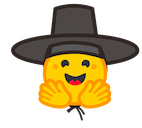


작성자: Hugging Face KREW, [김하림](https://github.com/harheem)

## 📚 RAG

### RAG (검색 증강 생성)
단순히 프롬프트를 작성하여 LLM이 항상 내가 원하는 작업을 수행할 수 있다면 좋겠지만, 현실은 그렇지 않습니다. 이럴 때, 선택할 수 있는 효과적인 방법은 프롬프트 일부에 '지식'을 제공하는 것입니다. 이렇게 제공된 지식을 컨텍스트라고 부르며, LLM이 주어진 작업을 수행하기 위해 필요한 정보를 제공합니다. 이 방법을 검색 증강 생성(Retrieval-Augmented Generation, RAG)이라고 합니다. RAG는 파인 튜닝을 하는 것보다 훨씬 적은 노력과 비용이 들어 많은 사람들이 선호하는 방법이며, RAG를 개선하기 위한 새로운 방법들이 빠르게 개발되고 있습니다.

RAG를 사용하면 지식의 격차, 사실적 오류, 그리고 잘못된 정보 생성(hallucination)과 같은 문제들을 줄일 수 있습니다. 특히 RAG는 최신 정보가 중요한 분야나 특정 도메인의 응용 프로그램에서 큰 강점을 발휘합니다. LLM을 특정 작업에 맞추어 다시 학습시킬 필요 없이 유연하게 활용할 수 있다는 점이 RAG의 핵심적인 이점입니다.

이렇게 LLM에 추가 지식을 제공하면, 모델이 원래 모르던 내용에 대해서도 정확한 답변을 할 수 있습니다. 항상 제가 직접 인터넷에서 자료를 검색하여 모델에게 정보를 추가로 제공하는 것은 의미가 없을 것입니다. 그렇다면, 사람의 개입 없이 시스템이 어떻게 해당 정보를 제공하도록 할 수 있을까요? 🤔

### RAG 구성 요소

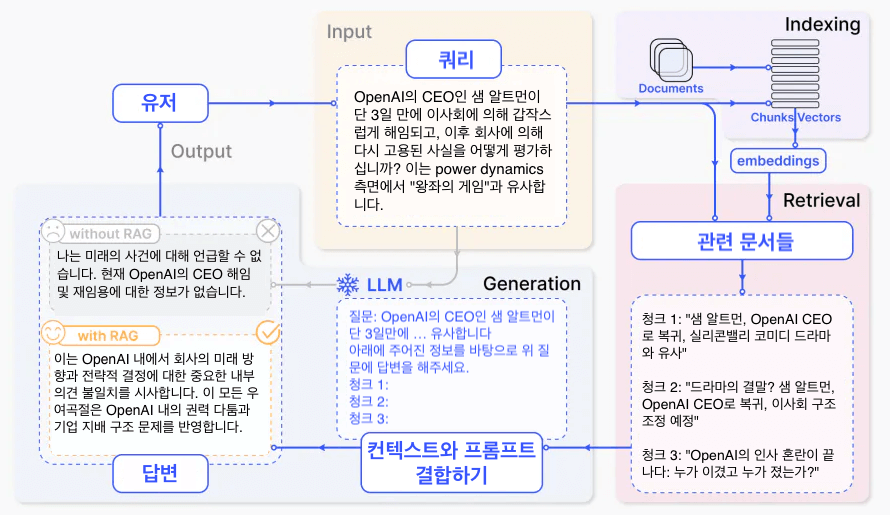
위 그림은 [Retrieval-Augmented Generation for Large
Language Models: A Survey](https://arxiv.org/pdf/2312.10997) 논문에서 RAG 프로세스의 대표적인 사례로 소개된 그림입니다.

#### 입력(Input)
LLM이 답변해야 할 질문을 의미합니다. RAG를 사용하지 않는 경우, LLM은 직접 질문에 대답하게 됩니다.

> Query: OpenAI의 CEO인 샘 알트먼이 단 3일 만에 이사회에 의해 갑작스럽게 해임되고, 이후 회사에 의해 다시 고용된 사실을 어떻게 평가하십니까? 이는 power dynamics 측면에서 "왕좌의 게임"과 유사합니다.

#### 인덱싱(Indexing)
RAG 시스템 구축의 첫 단계로, 다음 과정을 거칩니다:
1. 문서 분할: 대량의 텍스트 데이터를 관리하기 쉬운 작은 단위로 나눕니다. 예를 들어, 100페이지 분량의 책을 한 페이지씩 나누거나, 500자 단위로 분할할 수 있습니다. 이렇게 나눈 작은 단위를 '청크'라고 부릅니다.
2. 임베딩: 각 청크를 컴퓨터가 이해할 수 있는 형태로 변환합니다. 이 과정에서 자연어 처리 모델을 사용하여 각 청크를 수백 차원의 숫자 배열, 즉 벡터로 변환합니다. 이를 통해 텍스트의 의미를 수학적으로 표현할 수 있게 되며, 이후 텍스트 간의 유사성을 계산하는 데 활용됩니다.
3. 저장: 완성된 임베딩 벡터들을 효율적으로 저장하고 검색할 수 있는 특별한 데이터베이스에 보관합니다. 이러한 데이터베이스를 벡터 데이터베이스라고 부르며, 대규모 벡터 데이터를 빠르게 검색할 수 있도록 최적화되어 있습니다.

#### 검색(Retrieval)
사용자의 질문이 주어지면 다음 단계를 수행합니다:
1.  질문 임베딩: 사용자의 질문을 앞서 문서를 임베딩할 때 사용한 것과 동일한 방식으로 벡터로 변환합니다. 이렇게 하면 질문과 저장된 문서 청크들을 같은 '언어', 즉 벡터 공간에서 비교할 수 있게 됩니다.
2. 유사성 비교:  이 질문 벡터와 저장된 문서 청크 벡터 간의 유사성을 계산합니다. 이때 주로 사용되는 방법은 코사인 유사도나 유클리디안 거리 등의 수학적 메트릭입니다. 이 과정을 통해 각 문서 청크가 질문과 얼마나 관련이 있는지 점수화할 수 있습니다.
3. 관련 문서 선택: 이 유사도 점수를 바탕으로 가장 관련성 높은 상위 k개의 문서 청크를 선택합니다. 보통 상위 3개에서 5개 정도의 청크를 선택하며, 이렇게 선택된 청크들이 최종적으로 LLM에 제공되어 답변 생성에 활용됩니다.

> - 청크 1: "샘 알트먼, OpenAI CEO로 복귀, 실리콘밸리 코미디 드라마와 유사"
> - 청크 2: "드라마의 결말? 샘 알트먼, OpenAI CEO로 복귀, 이사회 구조 조정 예정"
> - 청크 3: "OpenAI의 인사 혼란이 끝나다: 누가 이겼고 누가 졌는가?"


👀 참고로, 벡터 데이터베이스의 종류에 따라 인덱싱 방법과 유사한 문서를 찾는 알고리즘이 다릅니다. 각 데이터베이스는 고유한 접근 방식과 최적화 전략을 가지고 있습니다. 따라서 벡터 데이터베이스를 선택할 때는 데이터의 규모, 필요한 검색 속도, 정확도, 그리고 사용 가능한 리소스 등을 고려해야 합니다. 또한, 대부분의 벡터 데이터베이스는 다양한 인덱싱 및 검색 옵션을 제공하므로, 같은 데이터베이스 내에서도 사용 사례에 따라 다른 방식을 선택할 수 있습니다.


#### 생성(Generation)
검색된 문서 청크는 원래의 질문과 결합되어 추가 컨텍스트를 형성합니다. 이 결합된 텍스트와 질문은 모델에 입력되어 최종 답변을 생성하는 데 사용됩니다.

> without RAG: 나는 미래의 사건에 대해 언급할 수 없습니다. 현재 OpenAI의 CEO 해임 및 재임용에 대한 정보가 없습니다.

> with RAG: 이는 OpenAI 내에서 회사의 미래 방향과 전략적 결정에 대한 중요한 내부 의견 불일치를 시사합니다. 이 모든 우여곡절은 OpenAI 내의 권력 다툼과 기업 지배 구조 문제를 반영합니다.

제공된 예시에서, 모델만을 사용했을 때 현재 사건에 대한 지식 부족으로 질문에 응답하지 못하였습니다. 반면, RAG를 사용할 때 시스템은 모델이 질문에 적절하게 대답할 수 있도록 필요한 정보를 제공해주었습니다. 🌟

### RAG 좋기만 할까? 생각보다 할 게 많은 RAG

RAG는 파인 튜닝에 비해 쉽게 만들 수 있다고 알려져 있습니다. 하려는 작업에 따라 그럴 수도 있고, 아닐 수도 있습니다. RAG를 잘하려면 생각보다 고려할게 많습니다.

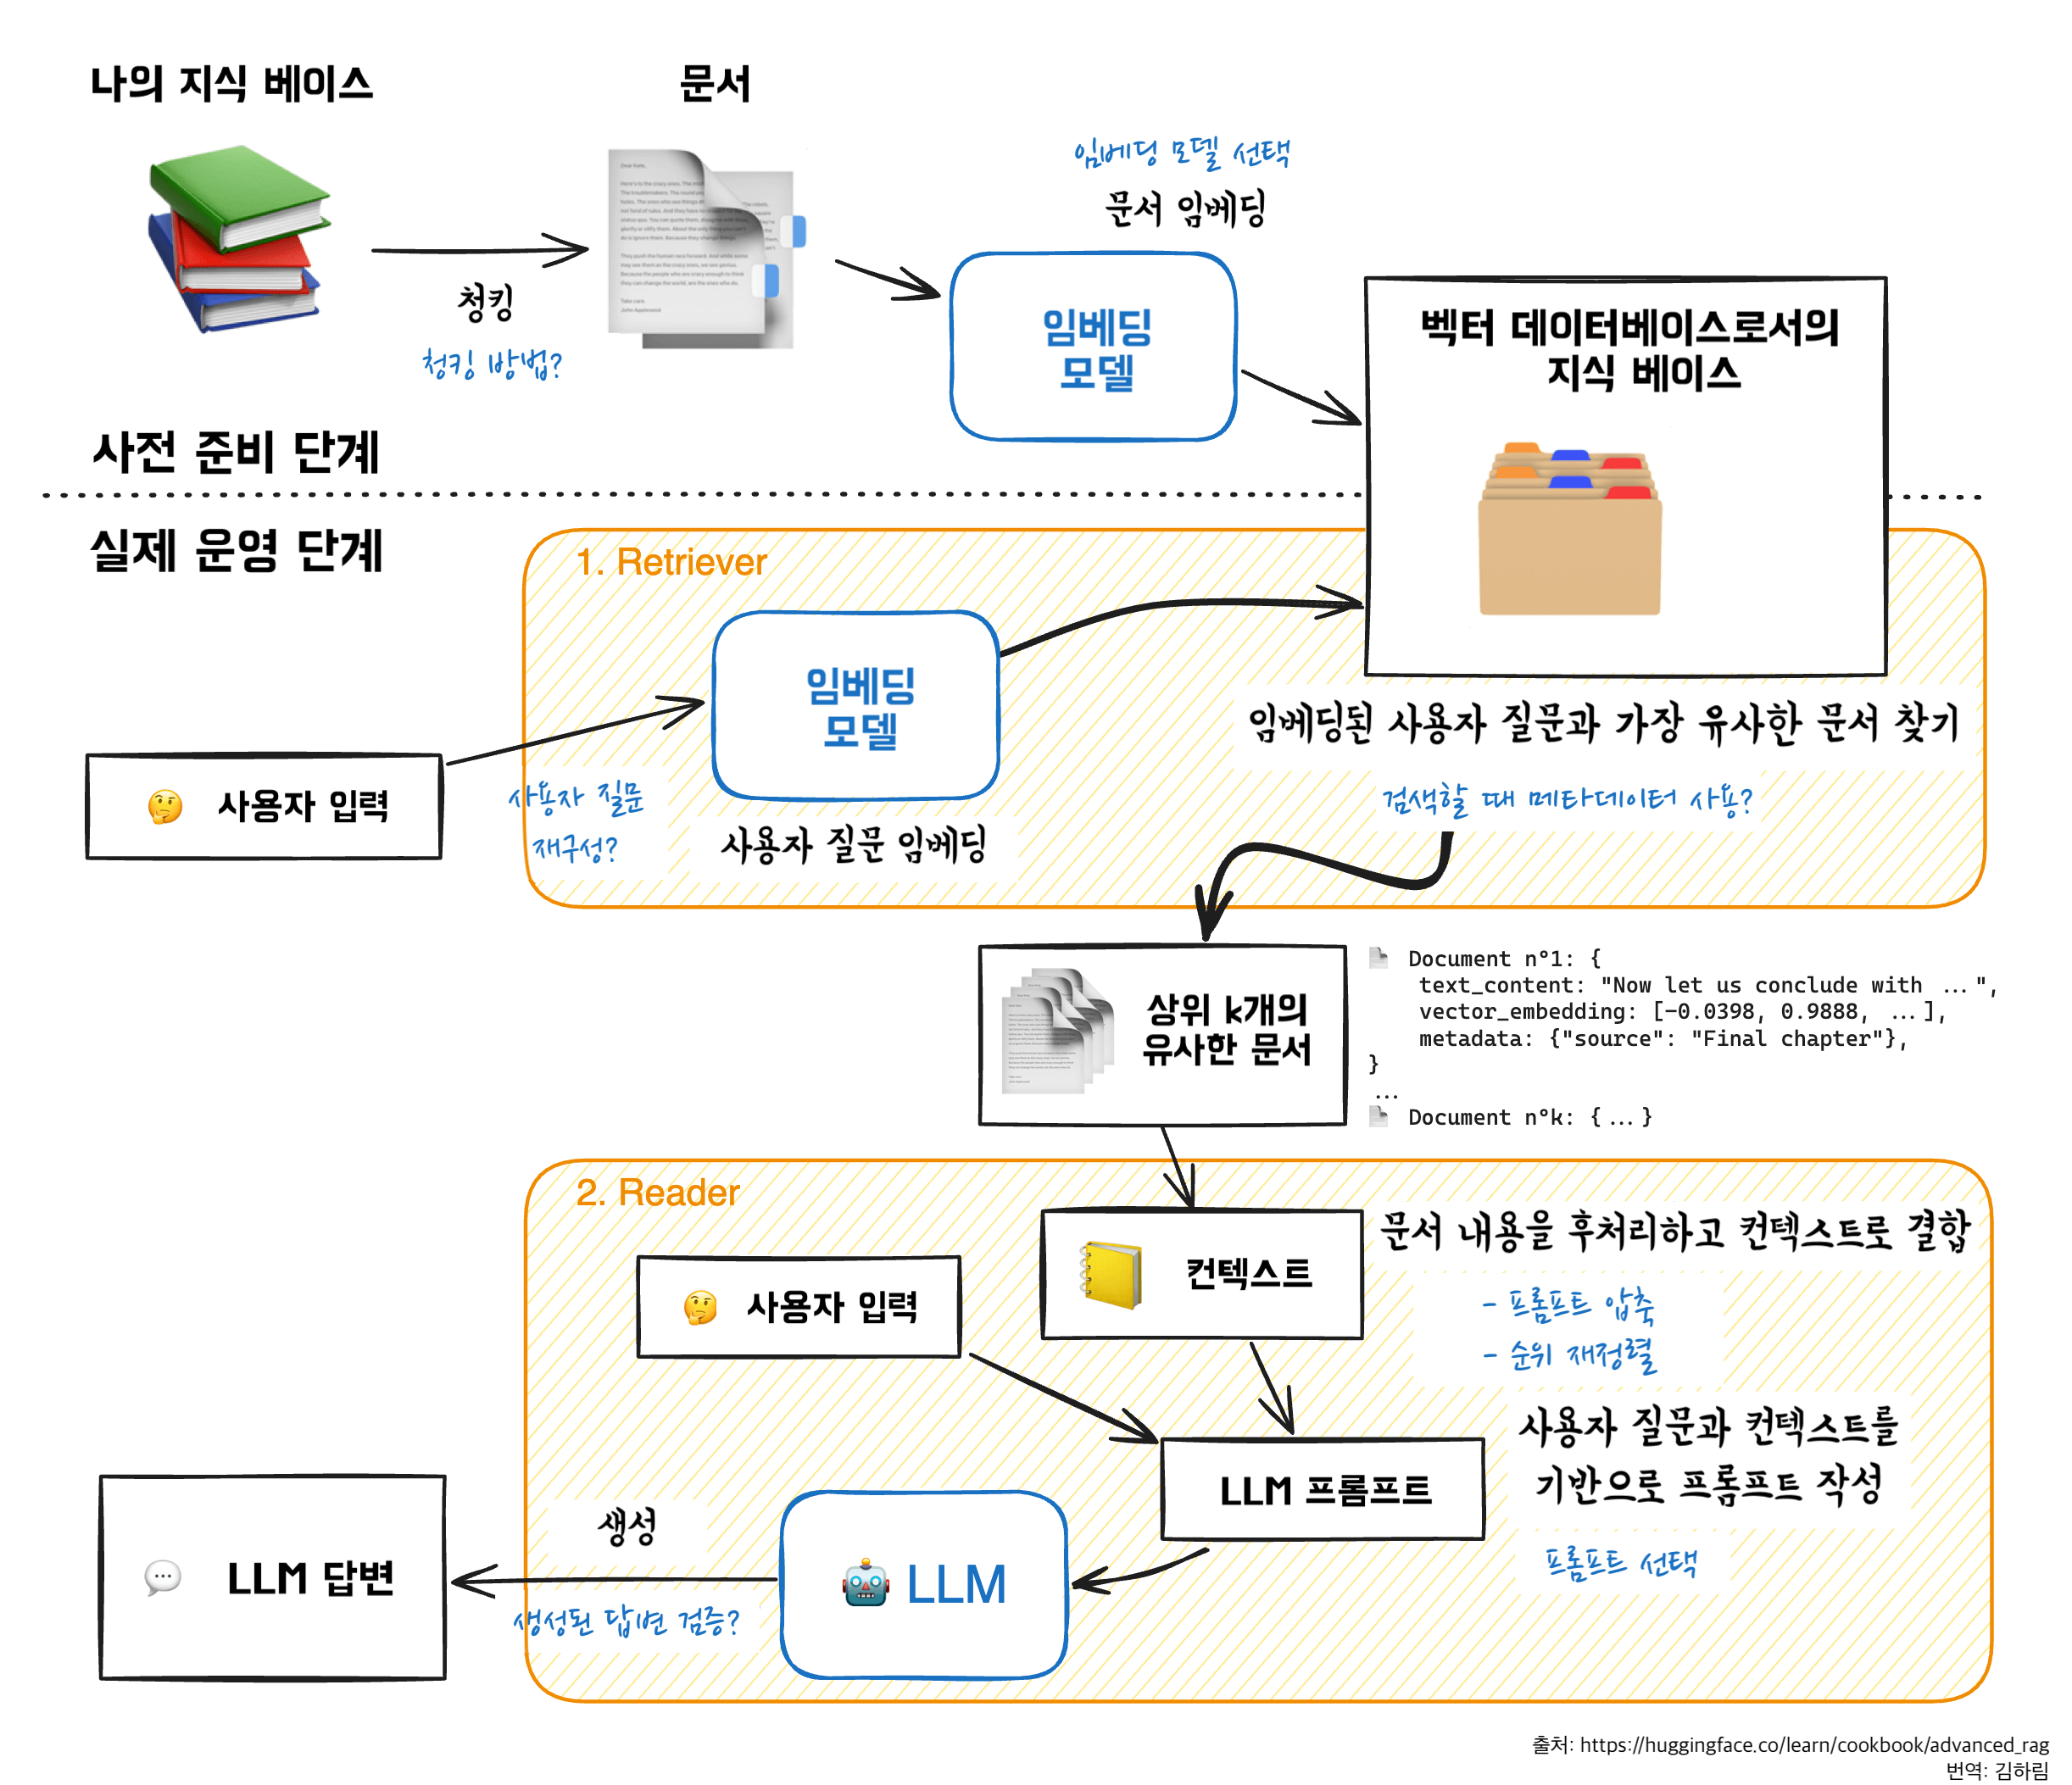

RAG(Retrieval-Augmented Generation)는 단순해 보이지만, 실제로는 복잡한 과정을 포함하고 있습니다. 이미지에서 볼 수 있듯이, RAG는 크게 사전 준비 단계와 실제 운영 단계로 나뉩니다.

사전 준비 단계에서는:
1. 지식 베이스가 될 문서들을 청킹(chunking)하고 처리합니다.
2. 각 청크를 임베딩 모델을 통해 벡터화합니다.
3. 이 벡터들을 벡터 데이터베이스에 저장합니다.

실제 운영 단계는 두 부분으로 구성됩니다:
1. Retriever: 사용자 입력을 받아 임베딩하고, 이를 바탕으로 벡터 데이터베이스에서 가장 유사한 문서를 검색합니다.
2. Reader: 검색된 문서와 사용자 입력을 결합하여 LLM에 전달할 프롬프트를 생성하고, LLM의 응답을 받아 최종 출력을 만듭니다.

각 단계마다 고려해야 할 사항들이 많습니다. 예를 들어:
- 어떤 임베딩 모델을 사용할까?
- 문서를 어떻게 효과적으로 청킹할까?
- 어떤 벡터 데이터베이스를 사용할까?
- Retriever의 성능을 어떻게 최적화할까?
- 어떤 프롬프트를 선택해야할까?
- 생성된 답변을 어떻게 검증할까?

이처럼 RAG는 단순히 문서를 검색해서 LLM에 넣는 것 이상의 복잡한 과정을 포함하며, 각 단계에서 많은 결정과 최적화가 필요하게 됩니다.

### RAG의 종류로는

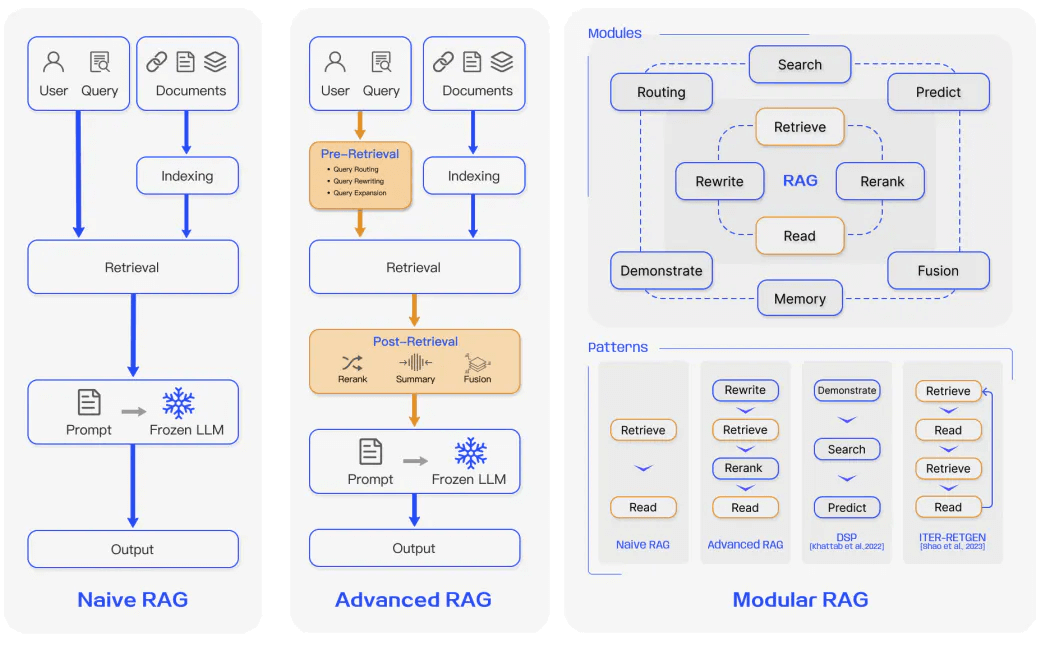

RAG(Retrieval-Augmented Generation)는 그 구현 방식과 복잡성에 따라 여러 종류로 나눌 수 있습니다. 주요한 세 가지 유형인 Naive RAG, Advanced RAG, Modular RAG에 알아보겠습니다.

#### 1. Naive RAG
Naive RAG는 가장 기본적이고 단순한 형태의 RAG입니다.
- 사용자 쿼리를 받습니다.
- 쿼리와 가장 관련있는 문서를 검색합니다.
- 검색된 문서와 원래 쿼리를 결합하여 LLM에 입력합니다.
- LLM이 생성한 응답을 사용자에게 반환합니다.

Naive RAG는 구현이 간단하고 빠르지만, 복잡한 쿼리나 여러 단계의 추론이 필요한 경우 성능이 제한적일 수 있습니다.

#### 2. Advanced RAG

Advanced RAG는 Naive RAG를 개선하여 더 복잡한 쿼리 처리와 정확한 정보 검색을 가능하게 합니다.
- 쿼리 확장: 원래 쿼리를 확장하여 더 많은 관련 정보를 검색합니다.
- 다중 검색: 여러 번의 검색을 수행하여 더 많은 관련 정보를 수집합니다.
- 재순위화: 검색된 문서들의 관련성을 재평가하여 더 적절한 정보를 선별합니다.
- 동적 프롬프팅: 검색된 정보에 따라 LLM에 전달되는 프롬프트를 동적으로 조정합니다.

Advanced RAG는 더 정확하고 포괄적인 응답을 생성할 수 있지만, 구현이 복잡하고 계산 비용이 높을 수 있습니다.

#### 3. Modular RAG

Modular RAG는 RAG 시스템을 여러 개의 독립적인 모듈로 나누어 구성합니다. Modular RAG의 장점은 유연성과 확장성입니다. 각 모듈을 독립적으로 개선하거나 교체할 수 있어, 시스템 전체의 성능을 점진적으로 향상시킬 수 있습니다. 또한 특정 도메인이나 작업에 맞춰 시스템을 쉽게 조정할 수 있습니다.

각 RAG 유형은 고유한 장단점을 가지고 있으며, 적용 상황과 요구사항에 따라 적절한 유형을 선택하거나 혼합하여 사용할 수 있습니다. 시스템의 복잡성, 성능 요구사항, 유지보수의 용이성 등을 고려하여 가장 적합한 RAG 유형을 선택하는 것이 중요합니다.

## 🧱 Naive RAG를 만들어보아요 (with 🤗 & 🦜️🔗)
1. 문서 불러오기
2. 문서 나누기
3. 벡터 데이터베이스에 임베딩 저장하기
4. 검색기 만들기
5. 프롬프트 준비하기
6. 체인 준비하기
7. 질문하고 답변받기

필요한 라이브러리 설치하기

In [ ]:
# 설치하는 데 2~3분 정도의 시간이 소요됩니다. 설치를 완료하고 세션을 다시 시작하세요.
!pip install -q nltk langchain langchain-community langchain-core unstructured sentence_transformers faiss-gpu openai selenium pypdf pacmap plotly_express nbformat rank_bm25 kiwipiepy bitsandbytes accelerate

### 1. 문서 불러오기

- LLM에게 제공할 지식이 담긴 문서를 불러오는 단계입니다.
- Hugging Face KREW가 번역한 🤗 Transformers 문서를 사용합니다.
- Langchain에서 제공하는 다양한 Loader를 살펴봅니다.

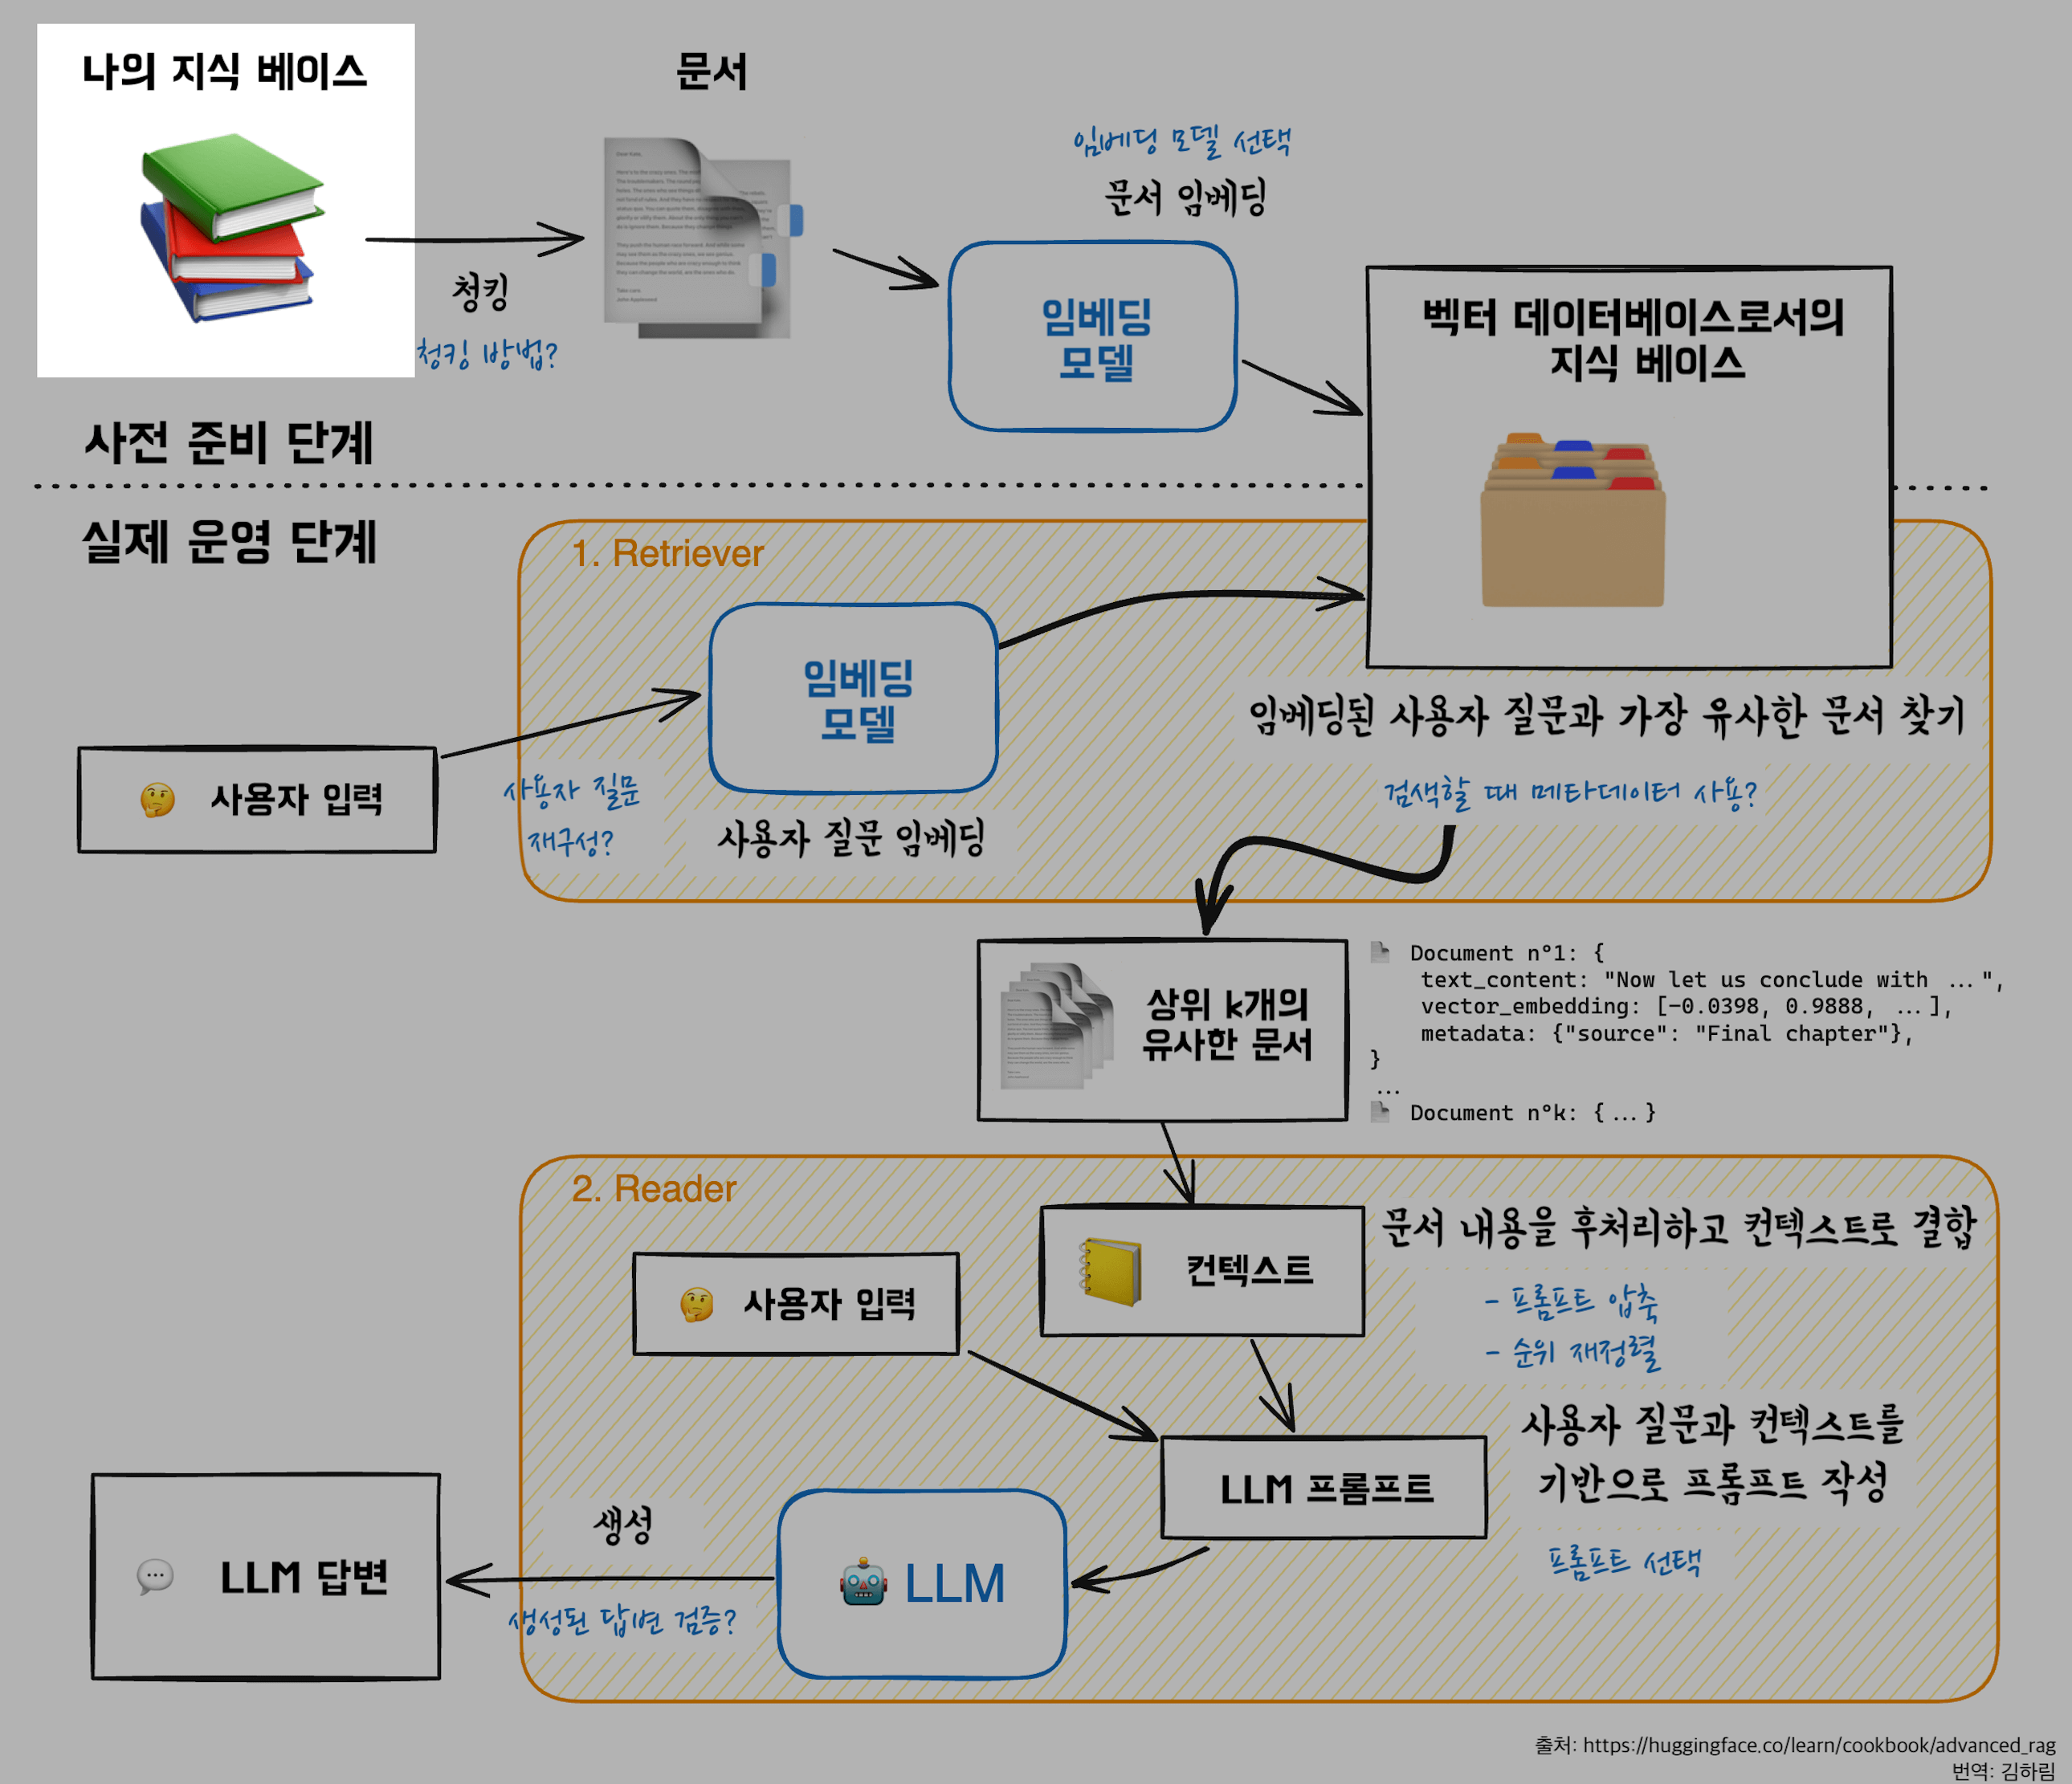

In [ ]:
from langchain_community.document_loaders import UnstructuredURLLoader
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


urls = [
    "https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/autoclass_tutorial",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/preprocessing",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/training",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/run_scripts",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tokenizer_summary",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/attention",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/pad_truncation",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_webserver",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks_explained",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/hpo_train",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/sequence_classification",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/token_classification",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/question_answering",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/language_modeling",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/masked_language_modeling",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/translation",
    "https://huggingface.co/docs/transformers/v4.41.3/ko/tasks/summarization",
]
loader = UnstructuredURLLoader(urls=urls)
docs = loader.load()

In [9]:
docs[1]

Document(metadata={'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/autoclass_tutorial'}, page_content='Transformers documentation\n\nAutoClass로 사전 학습된 인스턴스 로드\n\nTransformers\n\nSearch documentation\n\n시작하기\n\n🤗 Transformers\n\n둘러보기\n\n설치방법\n\n튜토리얼\n\nPipeline으로 추론하기\n\nAutoClass로 사전 학습된 인스턴스 로드하기\n\n데이터 전처리하기\n\n사전 학습된 모델 미세 조정하기\n\n스크립트로 학습하기\n\n🤗 Accelerate로 분산 학습 구성하기\n\n🤗 PEFT로 어댑터 로드 및 학습하기\n\n만든 모델 공유하기\n\n에이전트\n\n대규모 언어 모델로 생성하기\n\n태스크 가이드\n\n자연어처리\n\n오디오\n\n컴퓨터 비전\n\n멀티모달\n\n생성\n\n(번역중) 프롬프팅\n\n(번역중) 개발자 가이드\n\n🤗 Tokenizers 라이브러리에서 토크나이저 사용하기\n\n다국어 모델 추론하기\n\n모델별 API 사용하기\n\n사용자 정의 모델 공유하기\n\n(번역중) Templates for chat models\n\n(번역중) Trainer\n\nAmazon SageMaker에서 학습 실행하기\n\nONNX로 내보내기\n\nTFLite로 내보내기\n\nTorchScript로 내보내기\n\n(번역중) Benchmarks\n\n(번역중) Notebooks with examples\n\n커뮤니티 리소스\n\n사용자 정의 도구와 프롬프트\n\n문제 해결\n\n(번역중) Contribute new quantization method\n\n(번역중) 성능 및 확장성\n\n성능 및 확장성\n\n(번역중) Quantization\n\n(번역중) 효율적인 학습 기술들\n\n(번역중) Training on one GPU\n\n다중 

##### PyPDFLoader

[이 곳](https://www.contribution.ac/)에서 마음에 드는 pdf를 다운받아 직접 실행해 보세요.

> 💡 TIP
  - PyPDF 말고도, PDF 파일을 읽는 다양한 라이브러리가 있습니다.
  - 라이브러리에 따라서 문서를 읽어오는 방식이 차이가 나기에 다양한 라이브러리를 테스트해보면서 제일 성능이 좋은 라이브러리를 선택해보세요.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

file_path = (
    "/content/06. 2024 OSSCA_참여형_Project Guide_Hugging Face OSS.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

for page in pages:
  print(page.metadata, page)

##### 이 외에도
- 기본적인 Document loaders 가이드는 아래 문서에서 확인할 수 있어요.
  - [How to: load CSV data](https://python.langchain.com/v0.2/docs/how_to/document_loader_csv/)
  - [How to: load data from a directory](https://python.langchain.com/v0.2/docs/how_to/document_loader_directory/)
  - [How to: load HTML data](https://python.langchain.com/v0.2/docs/how_to/document_loader_html/)
  - [How to: load JSON data](https://python.langchain.com/v0.2/docs/how_to/document_loader_json/)
  - [How to: load Markdown data](https://python.langchain.com/v0.2/docs/how_to/document_loader_markdown/)
  - [How to: load Microsoft Office data](https://python.langchain.com/v0.2/docs/how_to/document_loader_office_file/)
  - [How to: load PDF files](https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/)
- Langchain에 있는 모든 Document loaders가 궁금하다면?
  - [Langchain Document loaders](https://python.langchain.com/v0.2/docs/integrations/document_loaders/)

### 2. 문서 나누기 ⭐

이 단계에서는 지식 기반 문서를 작은 단위(청크)로 나눕니다. 이렇게 나눈 각 조각은 LLM이 답변을 생성할 때 사용하는 기본 텍스트 단위로 활용됩니다. 이 작업의 목표는 의미적으로 연관된 텍스트 덩어리를 만드는 것이며, 각 단위는 충분한 컨텍스트를 포함해야 합니다. 너무 작은 단위는 컨텍스트가 부족해질 위험이 있고, 너무 큰 단위는 중요한 내용을 찾기 어렵게 만듭니다.

내 문서의 특성에 맞게 적합한 분할 방식을 선택해야 합니다.

> 문서 나누기에 대해 더 자세히 알고 싶은 분에게 [이 자료](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)를 강력하게 추천드립니다. 👍🏻

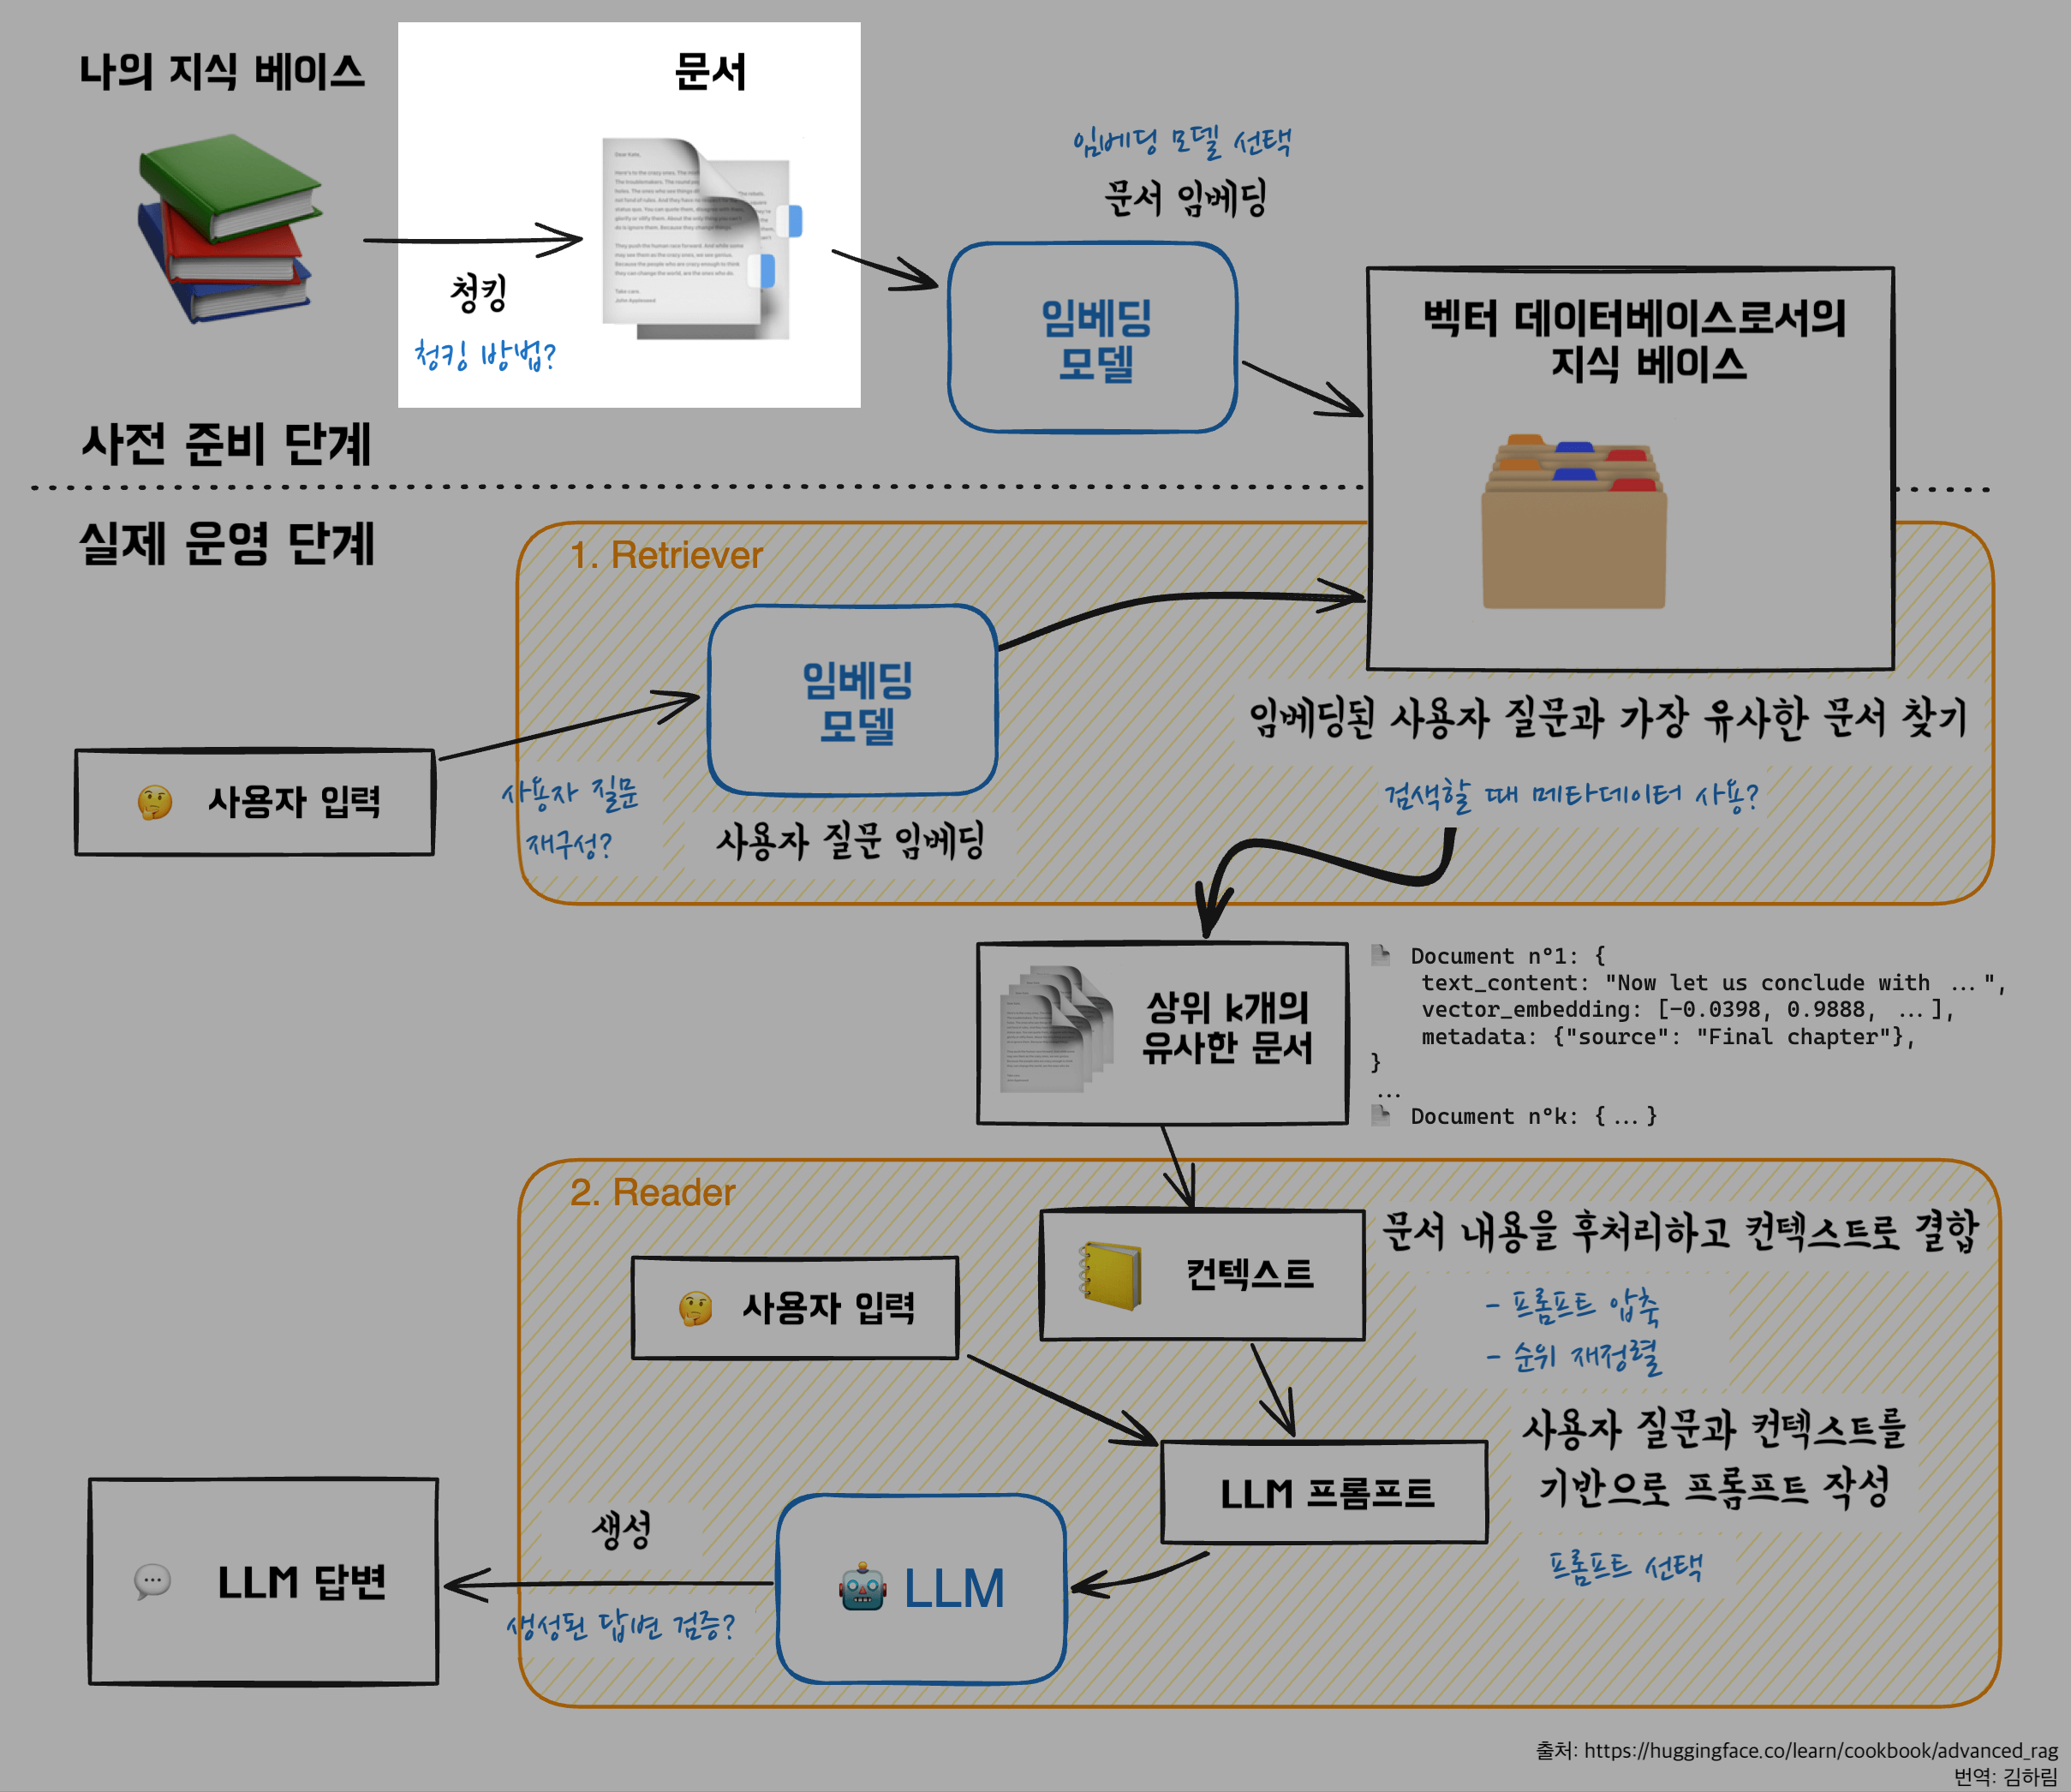

##### Custom

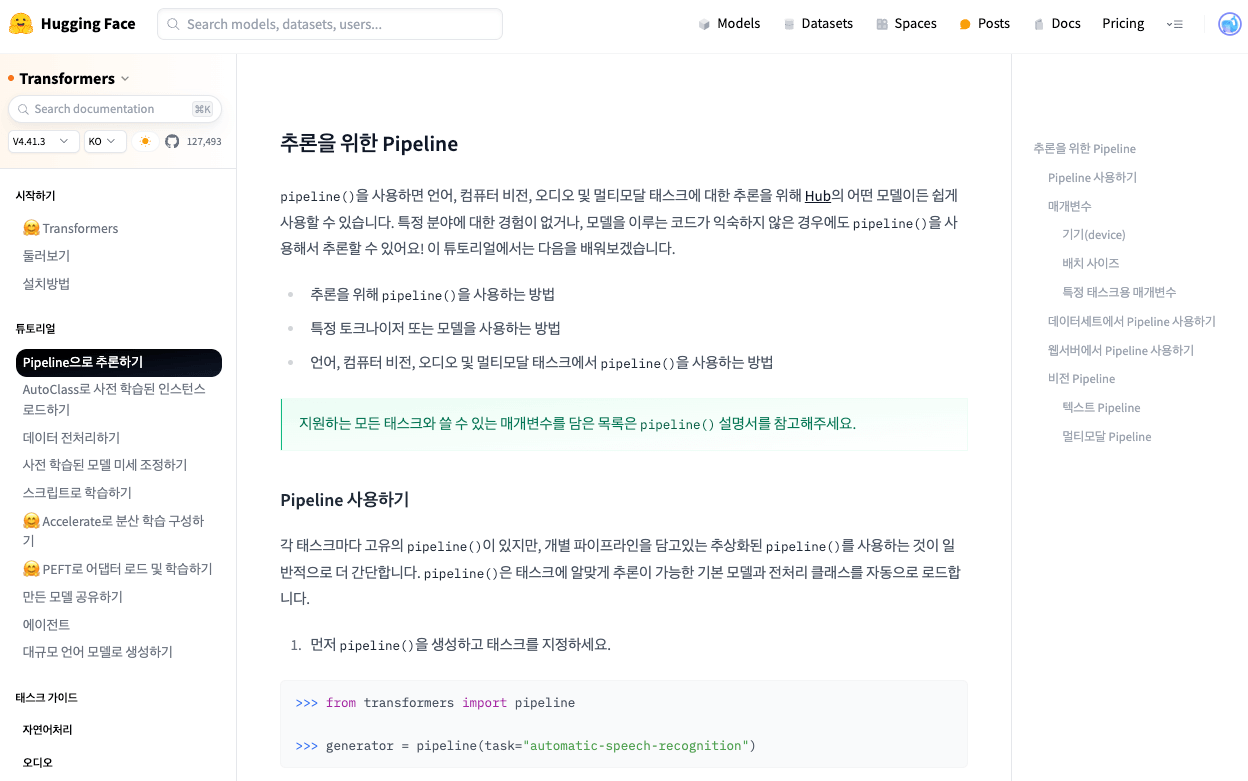

의미있는 단위로 나누는 것이 정말 중요하기 때문에 문서의 특성에 따라 어떻게 나눌지를 잘 정해야 합니다. 문서를 분할해주는 다양한 라이브러리가 존재하지만, 🤗 Transformers 문서를 살펴봤을 때 문단 별로 나누는 것이 가장 좋을 것 같아 ToC(Table of Contents)로 나눴습니다.

In [6]:
contents = [doc.page_content for doc in docs]
all_toc = [c.split("→")[-1].split('\n\n')[1:] for c in contents]
all_toc[0]

['추론을 위한 Pipeline',
 'Pipeline 사용하기',
 '매개변수',
 '기기(device)',
 '배치 사이즈',
 '특정 태스크용 매개변수',
 '데이터세트에서 Pipeline 사용하기',
 '웹서버에서 Pipeline 사용하기',
 '비전 Pipeline',
 '텍스트 Pipeline',
 '멀티모달 Pipeline']

In [8]:
from langchain_core.documents import Document

chunked_docs = []

for doc, toc_list in zip(docs, all_toc):
    cleaned_text = doc.page_content.split("to get started\n\n")[-1].split("< > Update on GitHub\n\n")[0]
    for idx, toc in enumerate(reversed(toc_list)):
        split_str = "\n\n"+ toc + "\n\n"
        if idx == len(toc_list)-1:
            split_str = toc + "\n\n"
        splited_text = cleaned_text.split(split_str)
        chunked_docs.append(Document(page_content=toc + ": " + splited_text[-1], metadata=doc.metadata))
        new_text = split_str.join(splited_text[:-1])
        if new_text != '':
            cleaned_text = new_text

for doc in chunked_docs[:2]:
  print(doc.metadata, doc)

{'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'} page_content='멀티모달 Pipeline: pipeline()은 여러 모달리티(역주: 오디오, 비디오, 텍스트와 같은 데이터 형태)를 지원합니다. 예시로 시각적 질의응답(VQA; Visual Question Answering) 태스크는 텍스트와 이미지를 모두 사용합니다. 그 어떤 이미지 링크나 묻고 싶은 질문도 자유롭게 전달할 수 있습니다. 이미지는 URL 또는 로컬 경로의 형태로 전달해주세요.

예를 들어 이 거래명세서 사진에서 거래명세서 번호를 묻고 싶다면,

Copied

>>>

from transformers

import pipeline

>>> vqa = pipeline(model=

"impira/layoutlm-document-qa")

>>> vqa(

...     image=

"https://huggingface.co/spaces/impira/docquery/resolve/2359223c1837a7587402bda0f2643382a6eefeab/invoice.png",

...     question=

"What is the invoice number?",

... )
[{

'score':

0.42514941096305847,

'answer':

'us-001',

'start':

16,

'end':

16}]

' metadata={'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'}
{'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'} page_content='텍스트 Pipeline: NLP 태스크를 위해 pipeline()을 사용하는 일도 거의 동일합니다.

Copied

>>

In [ ]:
len(chunked_docs)

134

### 3. 벡터 데이터베이스에 임베딩 저장하기

- 🤗 Hugging Face 모델을 통해 텍스트 임베딩을 생성합니다.
- 생성된 임베딩을 벡터 데이터베이스에 저장합니다.
- 벡터 데이터베이스에 저장된 문서의 개수를 확인합니다.
- 저장된 임베딩을 시각화 해봅니다.

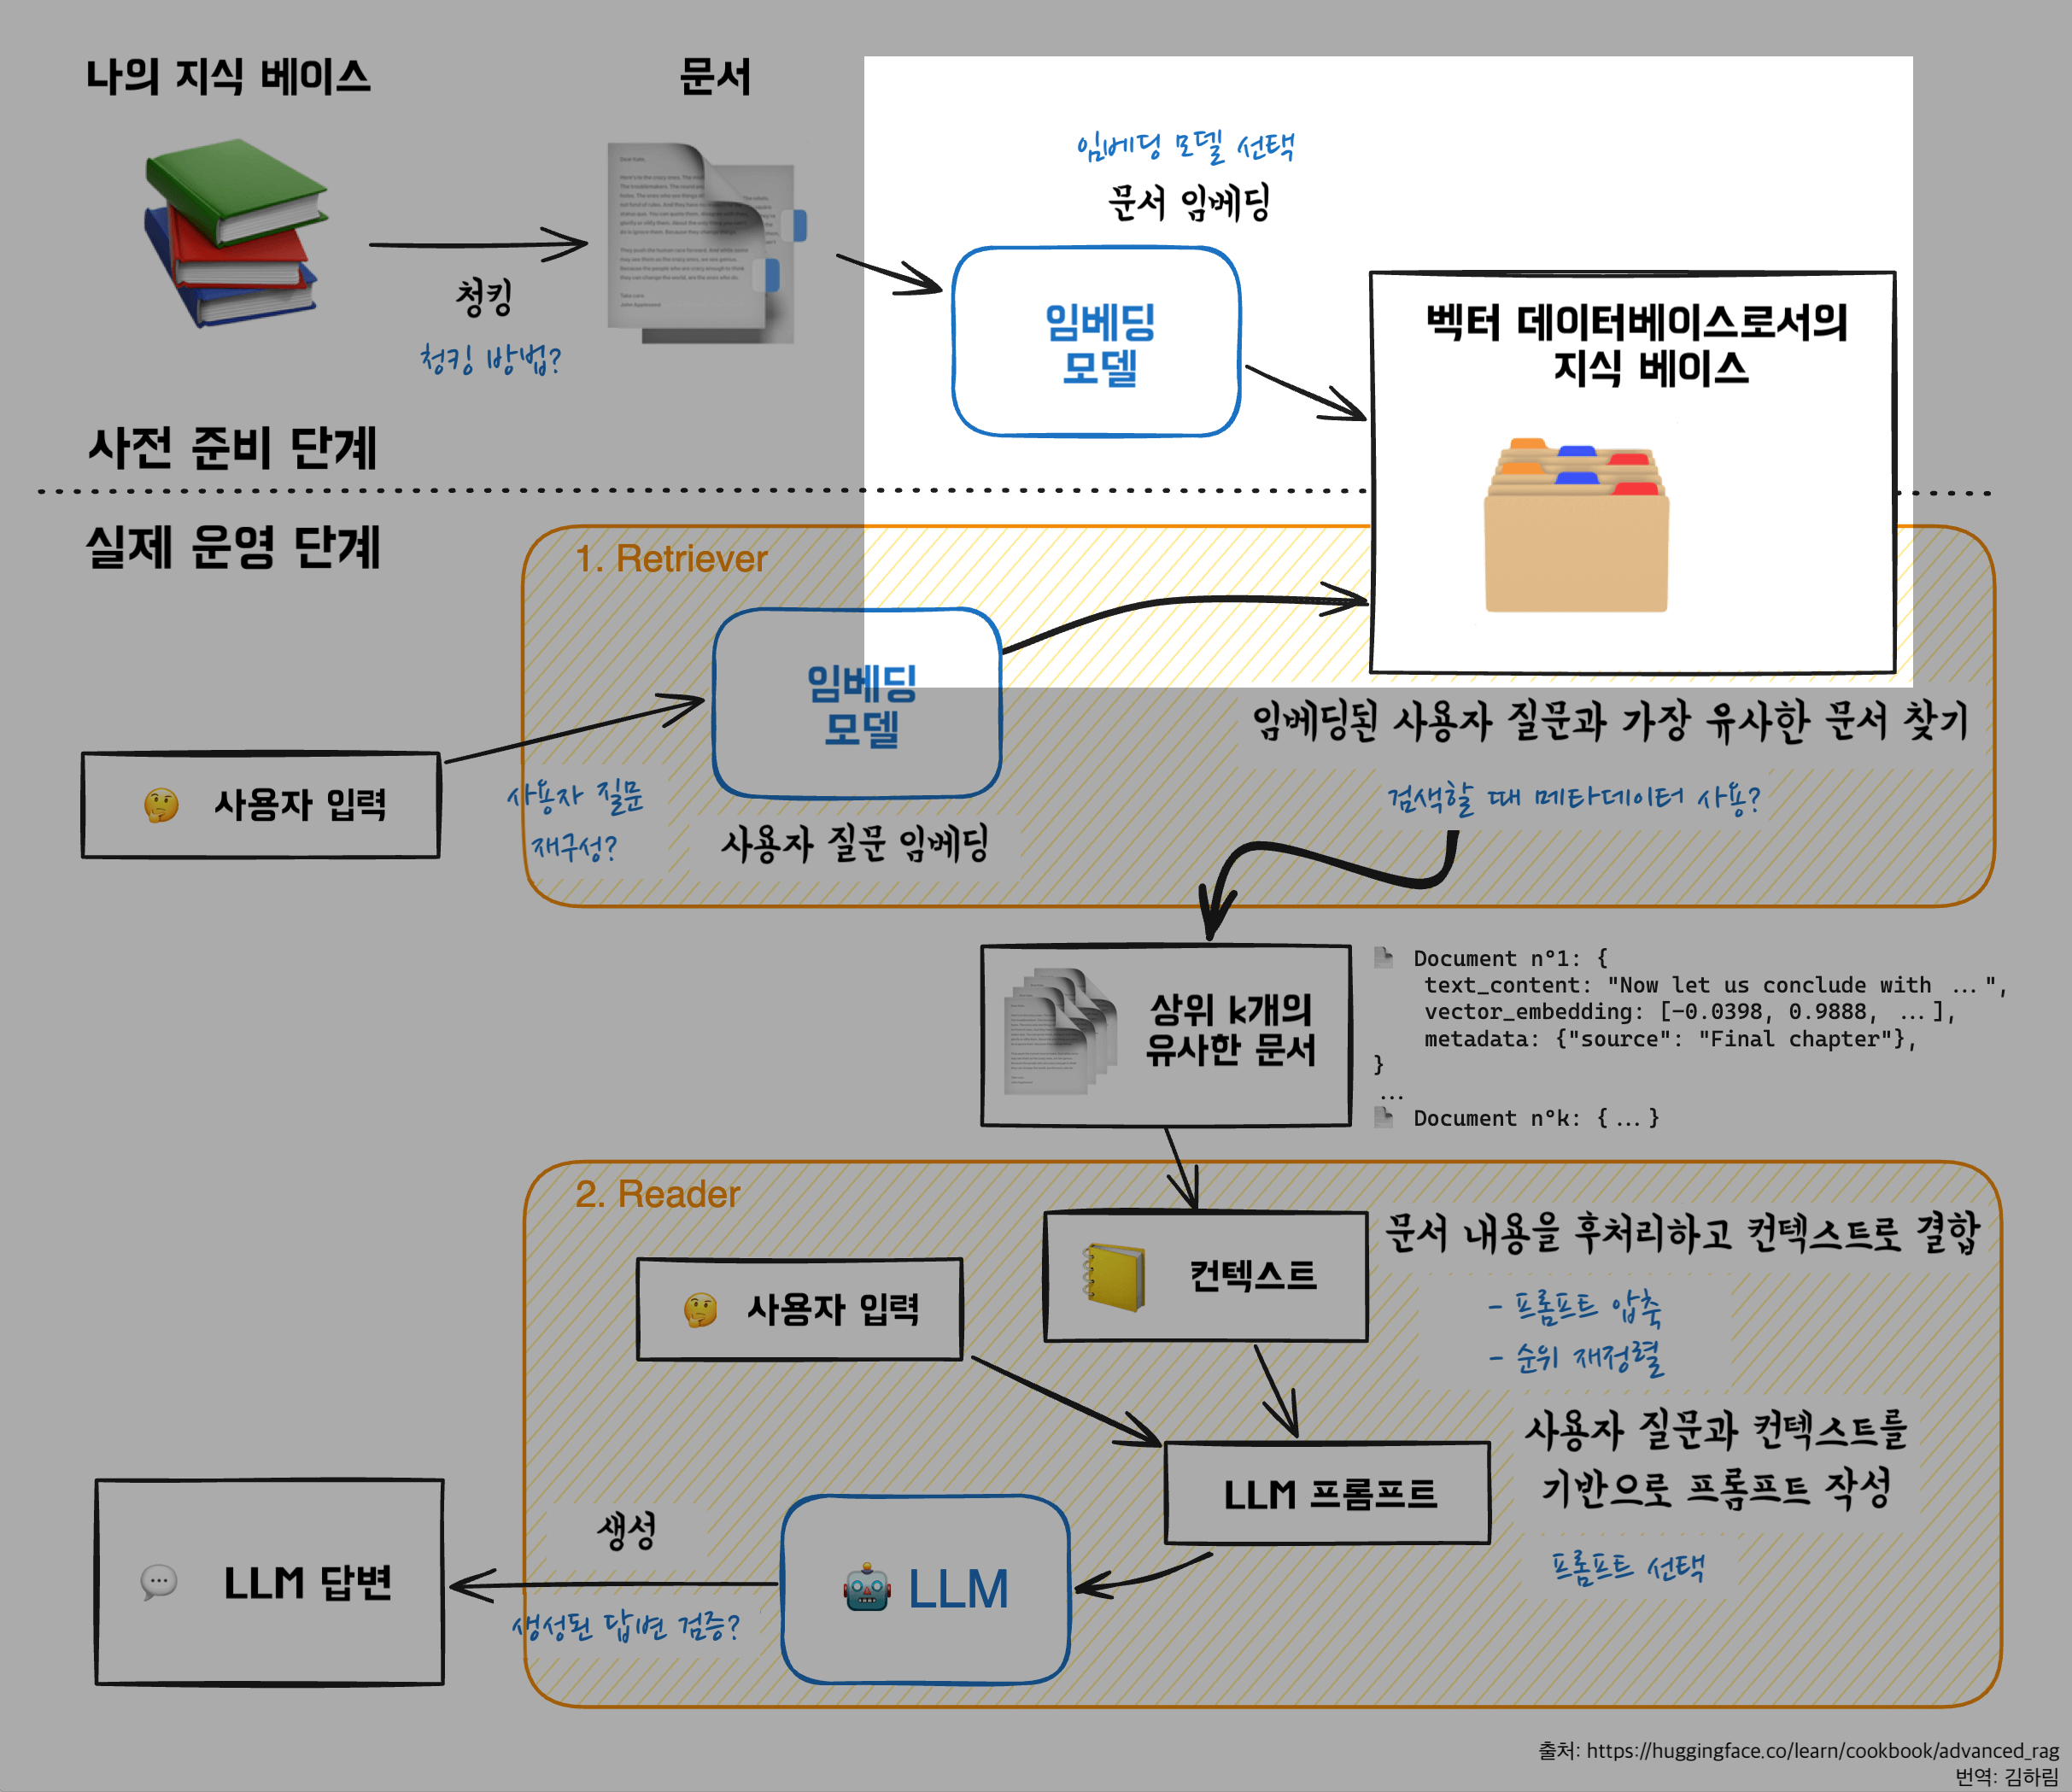

#### 임베딩 생성

In [ ]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"
embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        encode_kwargs={'normalize_embeddings': True},
    )
vectorstore = FAISS.from_documents(
    documents=chunked_docs,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE
)

vector_count = vectorstore.index.ntotal
print(f"저장된 벡터의 개수: {vector_count}")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

저장된 벡터의 개수: 134


#### 임베딩 시각화

질문과 저장된 임베딩 사이의 거리를 눈으로 확인해보도록 하겠습니다. 질문에 따라 그래프가 어떻게 달라지는지 확인해보세요.


In [ ]:
user_query = "어텐션 매커니즘이 무엇인가요?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
print(f"임베딩 차원 수: {len(query_vector)}")

임베딩 차원 수: 768


In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=133
)

embeddings_2d = [
    list(vectorstore.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(chunked_docs))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 133
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": chunked_docs[i].metadata["source"].split("ko/")[-1],
            "extract": chunked_docs[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(chunked_docs))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 2,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1100,
    height=800,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

### 4. 검색기 만들기

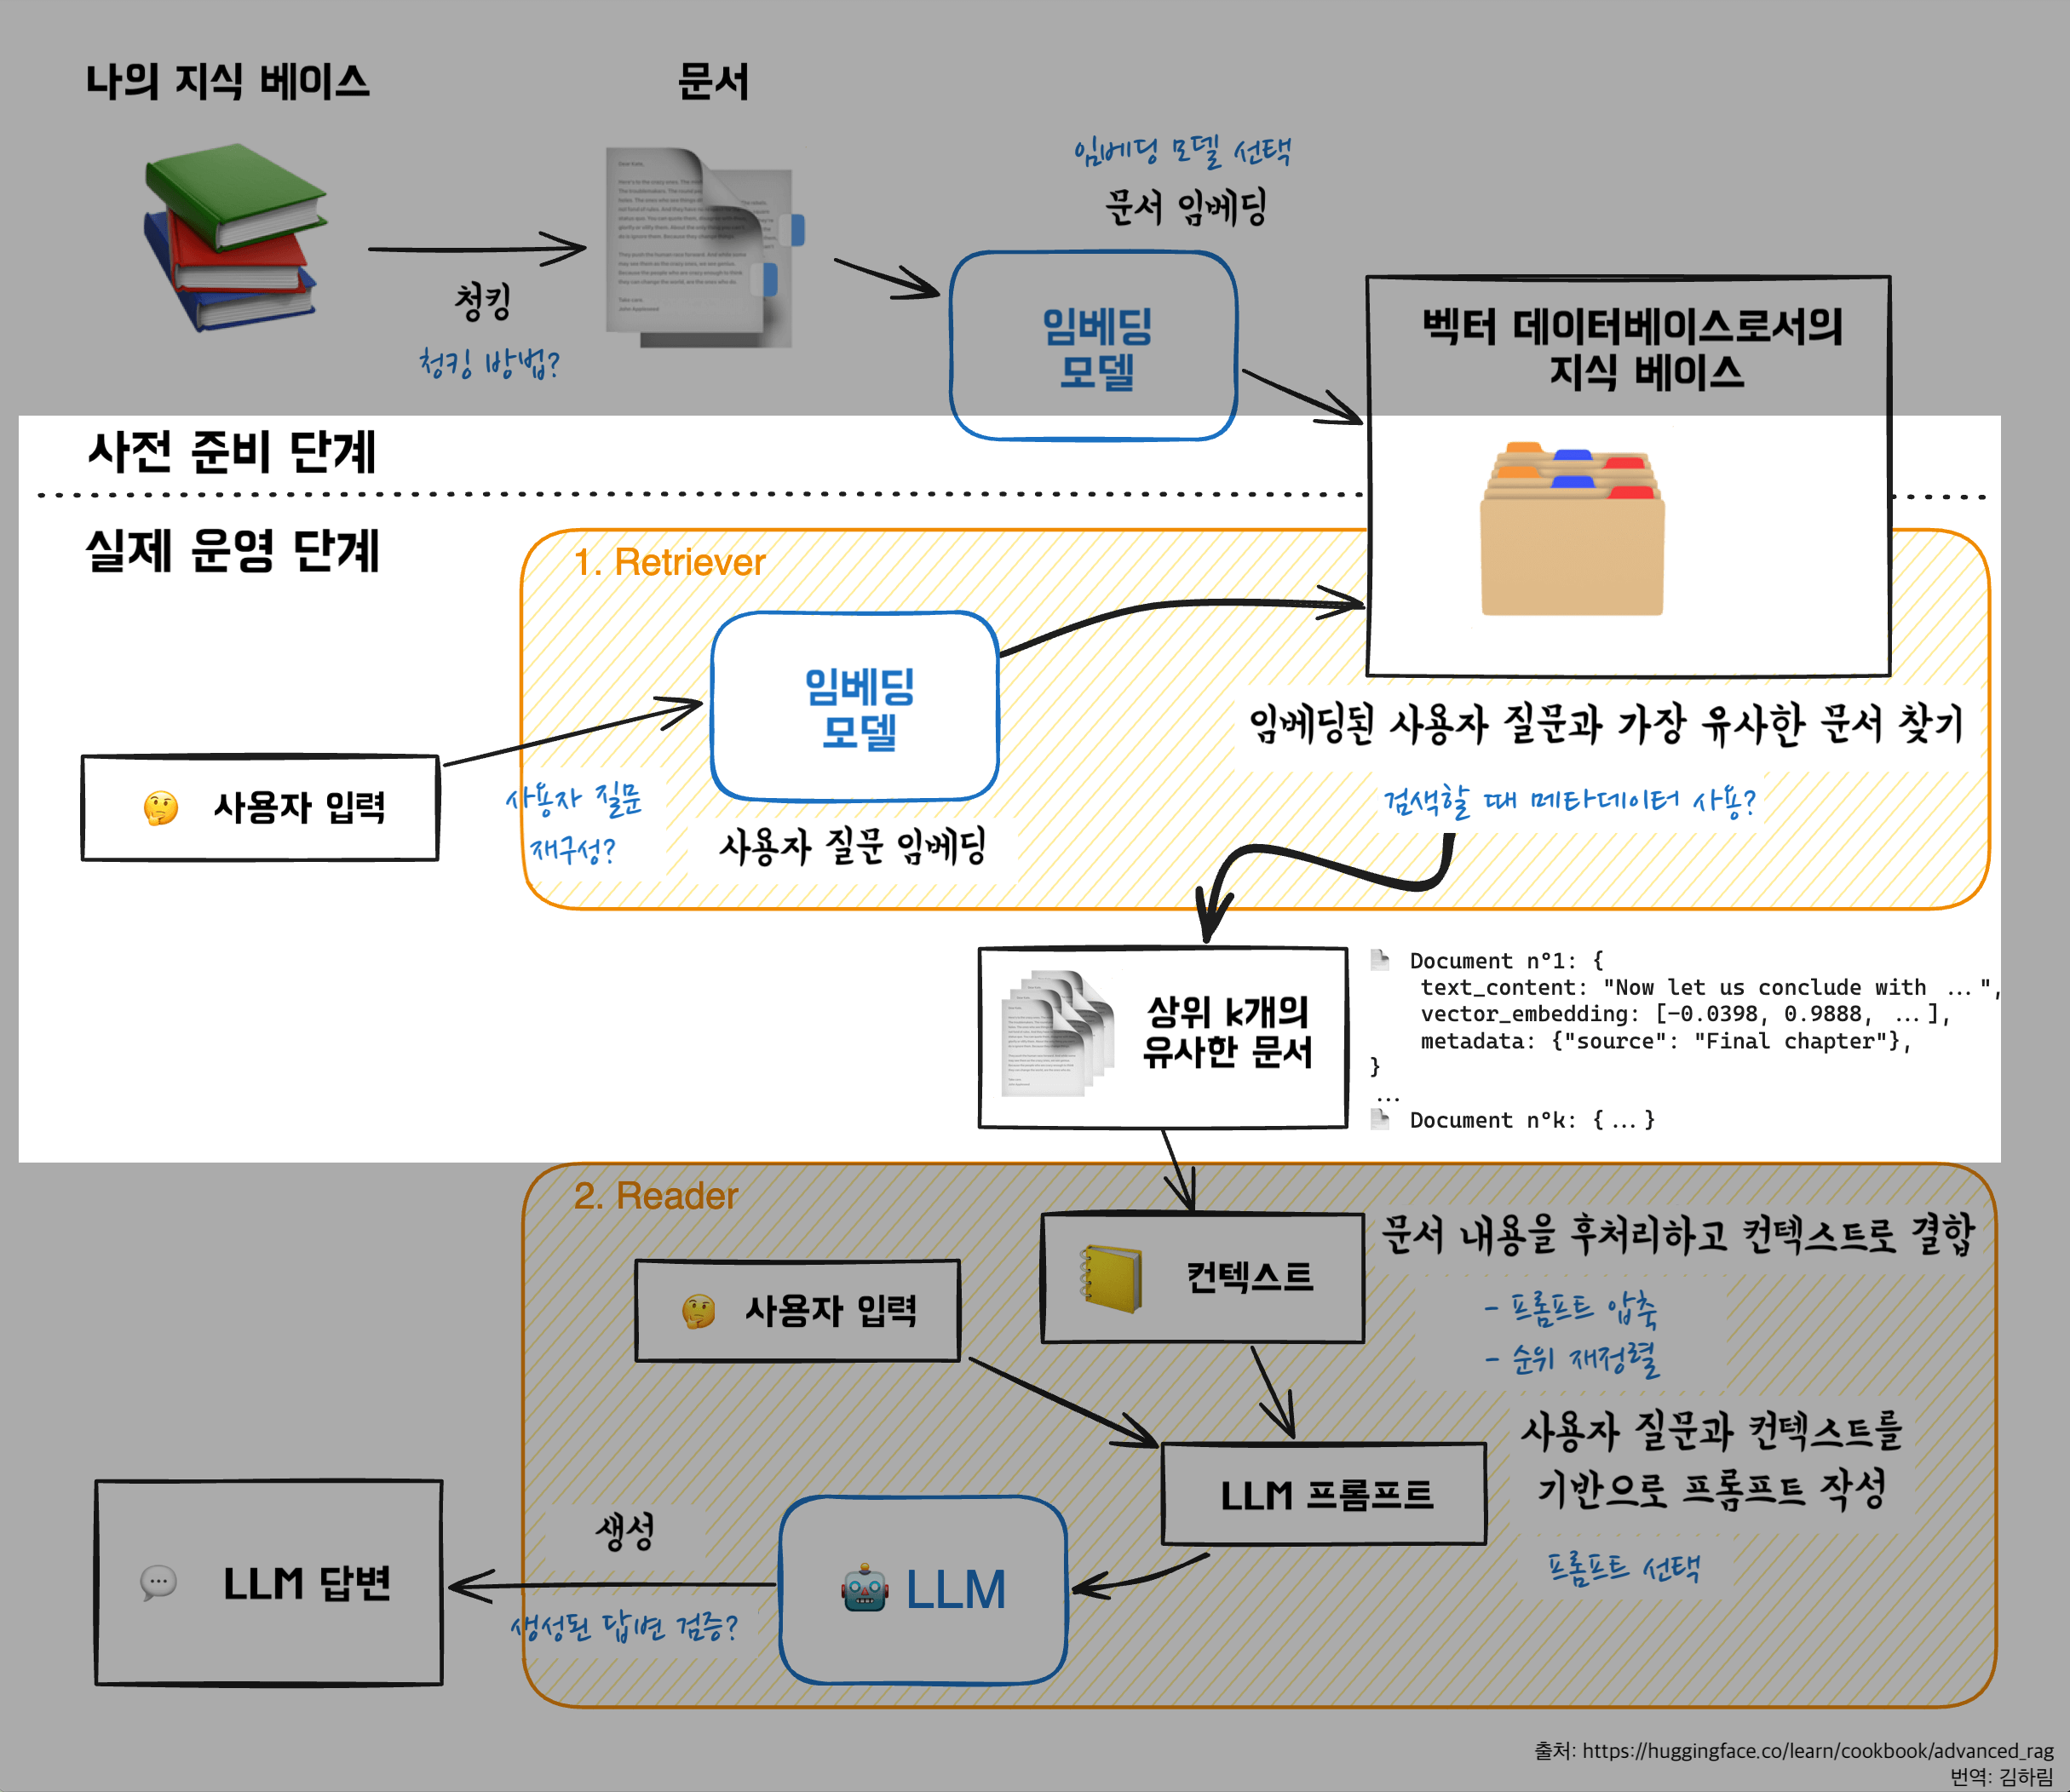

##### 기본 retriever

> 이 코드는 벡터 저장소에서 기본 설정을 사용하여 검색기를 초기화하고, 주어진 쿼리에 대해 검색을 수행하는 예시입니다.

In [ ]:
user_query = "pipeline이 무엇인지 알려줘."

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
basic_docs = retriever.invoke(user_query)
for doc in basic_docs:
  print(doc.metadata, doc)

{'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'} page_content='매개변수: pipeline()은 많은 매개변수를 지원합니다. 특정 태스크용인 것도 있고, 범용인 것도 있습니다.\n일반적으로 원하는 위치에 어디든 매개변수를 넣을 수 있습니다.\n\nCopied\n\ngenerator(model=\n\n"openai/whisper-large", my_parameter=\n\n1)\nout = generate(...)\n\n# This will use `my_parameter=1`.\nout = generate(..., my_parameter=\n\n2)\n\n# This will override and use `my_parameter=2`.\nout = generate(...)\n\n# This will go back to using `my_parameter=1`.\n\n중요한 3가지 매개변수를 살펴보겠습니다.' metadata={'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'}
{'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'} page_content='Pipeline 사용하기: 각 태스크마다 고유의 pipeline()이 있지만, 개별 파이프라인을 담고있는 추상화된 pipeline()를 사용하는 것이 일반적으로 더 간단합니다. pipeline()은 태스크에 알맞게 추론이 가능한 기본 모델과 전처리 클래스를 자동으로 로드합니다.\n\n먼저 pipeline()을 생성하고 태스크를 지정하세요.\n\nCopied\n\n>>>\n\nfrom transformers\n\nimport pipeline\n\n>>> generator = pipeline(task=\n\n"au

##### mmr retriever

> MMR, 또는 Maximal Marginal Relevance는 정보 검색 및 텍스트 요약에서 사용되는 방법으로, 문서나 텍스트 조각들을 선택할 때 다양성과 관련성을 균형 있게 유지하는 것을 목표로 합니다. 이는 특히 검색 시스템이나 요약 시스템에서 유사한 정보가 반복되는 것을 방지하고, 가능한 한 많은 새로운 정보를 제공하기 위해 사용됩니다.

MMR에 대해 잘 설명된 문서는 [이 곳](https://wikidocs.net/231585)에서 확인할 수 있어요.

In [ ]:
mmr_retriever = vectorstore.as_retriever(search_type="mmr")
mmr_docs = mmr_retriever.invoke(user_query)
for doc in mmr_docs:
  print(doc.metadata, doc)

{'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'} page_content='매개변수: pipeline()은 많은 매개변수를 지원합니다. 특정 태스크용인 것도 있고, 범용인 것도 있습니다.\n일반적으로 원하는 위치에 어디든 매개변수를 넣을 수 있습니다.\n\nCopied\n\ngenerator(model=\n\n"openai/whisper-large", my_parameter=\n\n1)\nout = generate(...)\n\n# This will use `my_parameter=1`.\nout = generate(..., my_parameter=\n\n2)\n\n# This will override and use `my_parameter=2`.\nout = generate(...)\n\n# This will go back to using `my_parameter=1`.\n\n중요한 3가지 매개변수를 살펴보겠습니다.' metadata={'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'}
{'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'} page_content='추론을 위한 Pipeline: pipeline()을 사용하면 언어, 컴퓨터 비전, 오디오 및 멀티모달 태스크에 대한 추론을 위해 Hub의 어떤 모델이든 쉽게 사용할 수 있습니다. 특정 분야에 대한 경험이 없거나, 모델을 이루는 코드가 익숙하지 않은 경우에도 pipeline()을 사용해서 추론할 수 있어요! 이 튜토리얼에서는 다음을 배워보겠습니다.\n\n추론을 위해 pipeline()을 사용하는 방법\n\n특정 토크나이저 또는 모델을 사용하는 방법\n\n언어, 컴퓨터 비전, 오디오 및 멀티모달 태스크에서 pipe

##### score threshold retriever

> 이 코드는 유사도 점수 임계값을 사용하여 검색기를 설정하고 쿼리에 대해 검색을 수행합니다. 이를 통해 사용자는 입력된 쿼리와 일정 수준 이상 유사한 결과만을 얻을 수 있습니다. 이는 검색 결과의 정확성을 높이고, 쿼리와 관련 없는 문서들을 필터링하는 데 유용합니다.

In [ ]:
score_retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.3}
)
score_retriever.invoke(user_query)

[Document(page_content='매개변수: pipeline()은 많은 매개변수를 지원합니다. 특정 태스크용인 것도 있고, 범용인 것도 있습니다.\n일반적으로 원하는 위치에 어디든 매개변수를 넣을 수 있습니다.\n\nCopied\n\ngenerator(model=\n\n"openai/whisper-large", my_parameter=\n\n1)\nout = generate(...)\n\n# This will use `my_parameter=1`.\nout = generate(..., my_parameter=\n\n2)\n\n# This will override and use `my_parameter=2`.\nout = generate(...)\n\n# This will go back to using `my_parameter=1`.\n\n중요한 3가지 매개변수를 살펴보겠습니다.', metadata={'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'})]

### 5. 프롬프트 준비하기

> 이 실습에서는 Langchain 라이브러리를 사용하여 QA(Question-Answering) Assistant의 프롬프트를 생성하는 방법을 보여줍니다. 생성된 프롬프트는 주어진 문맥(Context)과 질문(Question)에 기반하여 답변을 생성하는 데 사용됩니다.

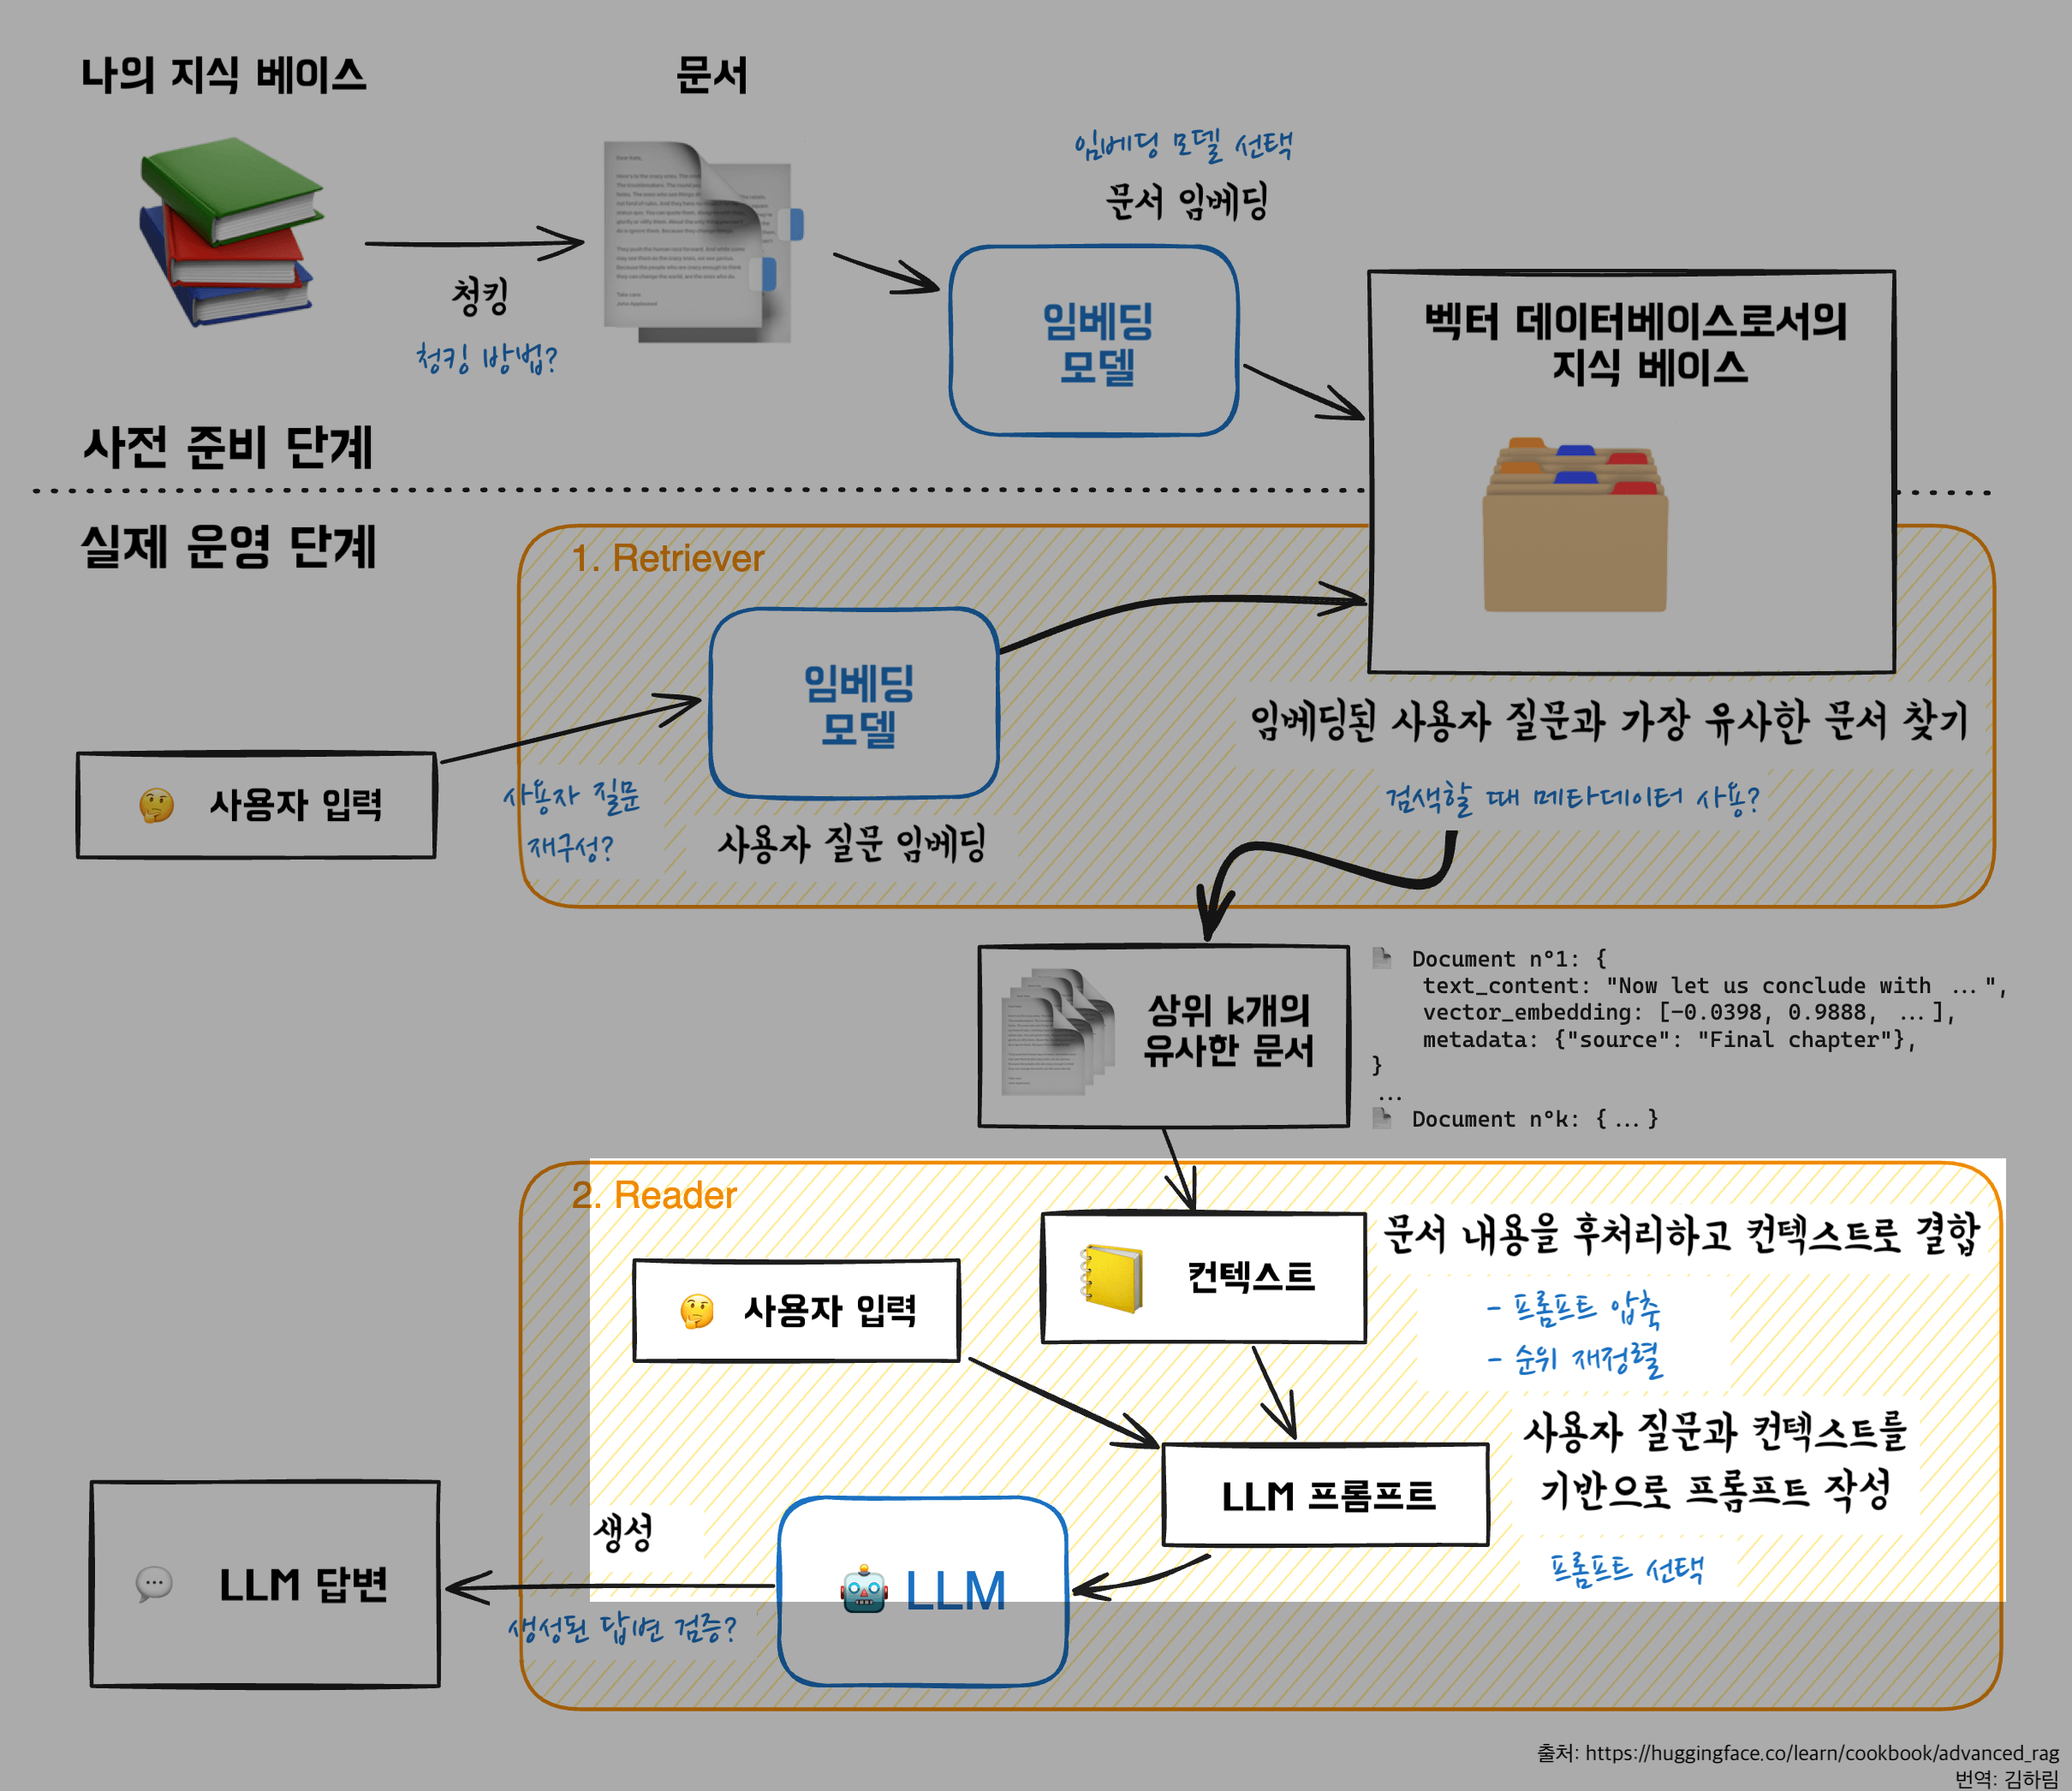

> 모델마다 적합한 프롬프트가 존재한다는 것을 알아두세요!

- Llama 3
  ```python
  template = """
      <|begin_of_text|>
      <|start_header_id|>system<|end_header_id|>
      당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
      최소 3문장 최대 5문장으로 답변하세요.
      주어진 Context가 없다면 "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
      <|eot_id|>
      <|start_header_id|>user<|end_header_id|>
      Context: {context}
      Question: {question}
      <|eot_id|>
      <|start_header_id|>assistant<|end_header_id|>
      Answer:
      """
    ```

- OpenAI
  ```python
    prompt = ChatPromptTemplate.from_messages([
      ("system", """당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
      최소 3문장 최대 5문장으로 답변하세요. 만약 Context를 다 확인해도 정보가 없거나 주어진 Context가 없다면 "정보가 부족하여 답변할 수 없습니다."를 출력하세요."""),
      ("user", """---
      Context: {context}
      ---
      Question: {question}"""),
  ])
  ```

In [ ]:
from langchain import PromptTemplate

# mistral prompt template
template = """
    <s>[INST] 당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
    최소 3문장 최대 5문장으로 답변하세요.
    주어진 Context가 없다면 "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
    Context: {context}
    Question: {question} [/INST]
    Answer:
    """

# Added prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=template
)

prompt.pretty_print()


    <s>[INST] 당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
    최소 3문장 최대 5문장으로 답변하세요.
    주어진 Context가 없다면 "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
    Context: {context}
    Question: {question} [/INST]
    Answer:
    


### 6. Chain 구성하기 ⛓️
1. retriever를 사용하여 질문과 유사한 문서를 검색합니다.
2. format_docs를 사용하여 검색된 문서를 텍스트로 변환합니다.
3. 이전의 정의한 prompt 템플릿으로 질문과 컨텍스트를 합칩니다.
4. llm을 사용하여 답변을 생성합니다.
5. StrOutputParser를 사용하여 출력을 파싱합니다.

In [ ]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import pipeline
import torch


def format_docs(docs):
    print(docs)
    return "\n\n".join(doc.page_content for doc in docs)

READER_MODEL_NAME = "yanolja/EEVE-Korean-Instruct-10.8B-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True

)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

### 7. Q&A 하기
1. RAG 체인을 사용하여 질문에 대한 답변을 생성합니다.
2. 질문과 해당 답변을 확인합니다.

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=READER_LLM)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning:

The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.



In [ ]:
question = "Hugging Face Transformers에서 pipeline은 어떤 매개변수를 사용해? 코드도 알려줘."

result = rag_chain.invoke(question)
ans = result.replace('.','.\n')
print(f"Question: {question}")
print(ans)
print('--------')

[Document(page_content='매개변수: pipeline()은 많은 매개변수를 지원합니다. 특정 태스크용인 것도 있고, 범용인 것도 있습니다.\n일반적으로 원하는 위치에 어디든 매개변수를 넣을 수 있습니다.\n\nCopied\n\ngenerator(model=\n\n"openai/whisper-large", my_parameter=\n\n1)\nout = generate(...)\n\n# This will use `my_parameter=1`.\nout = generate(..., my_parameter=\n\n2)\n\n# This will override and use `my_parameter=2`.\nout = generate(...)\n\n# This will go back to using `my_parameter=1`.\n\n중요한 3가지 매개변수를 살펴보겠습니다.', metadata={'source': 'https://huggingface.co/docs/transformers/v4.41.3/ko/pipeline_tutorial'}), Document(page_content='텍스트 Pipeline: NLP 태스크를 위해 pipeline()을 사용하는 일도 거의 동일합니다.\n\nCopied\n\n>>>\n\nfrom transformers\n\nimport pipeline\n\n>>>\n\n# This model is a `zero-shot-classification` model.\n\n>>>\n\n# It will classify text, except you are free to choose any label you might imagine\n\n>>> classifier = pipeline(model=\n\n"facebook/bart-large-mnli")\n\n>>> classifier(\n\n...\n\n"I have a problem with my iphone that needs to be resolved asap!!",\n\

## Advanced Retriever 기법 배우기

- [How to: use a vector store to retrieve data](https://python.langchain.com/v0.2/docs/how_to/vectorstore_retriever/)
- [How to: generate multiple queries to retrieve data for](https://python.langchain.com/v0.2/docs/how_to/MultiQueryRetriever/)
- [How to: use contextual compression to compress the data retrieved](https://python.langchain.com/v0.2/docs/how_to/contextual_compression/)
- [How to: write a custom retriever class](https://python.langchain.com/v0.2/docs/how_to/custom_retriever/)
- [How to: add similarity scores to retriever results](https://python.langchain.com/v0.2/docs/how_to/add_scores_retriever/)
- [How to: combine the results from multiple retrievers](https://python.langchain.com/v0.2/docs/how_to/ensemble_retriever/)
- [How to: reorder retrieved results to mitigate the "lost in the middle" effect](https://python.langchain.com/v0.2/docs/how_to/long_context_reorder/)
- [How to: generate multiple embeddings per document](https://python.langchain.com/v0.2/docs/how_to/multi_vector/)
- [How to: retrieve the whole document for a chunk](https://python.langchain.com/v0.2/docs/how_to/parent_document_retriever/)
- [How to: generate metadata filters](https://python.langchain.com/v0.2/docs/how_to/self_query/)
- [How to: create a time-weighted retriever](https://python.langchain.com/v0.2/docs/how_to/time_weighted_vectorstore/)
- [How to: use hybrid vector and keyword retrieval](https://python.langchain.com/v0.2/docs/how_to/hybrid/)

세션을 다시 시작하고 아래 코드를 실행하세요.
아래 예제를 실행하기 위해서는 Hugging Face Endpoint URL과 Hugging Face Token이 필요합니다.

Hugging Face Endpoint URL 생성 방법:
- Hugging Face 계정으로 로그인합니다. (없다면 먼저 가입해주세요)
- https://huggingface.co/inference-endpoints 페이지로 이동합니다.
- "Create an endpoint" 버튼을 클릭합니다.
- 사용하고자 하는 모델을 선택합니다. (예: "yanolja/EEVE-Korean-Instruct-10.8B-v1.0")
- 필요한 설정(하드웨어, 스케일링 옵션 등)을 선택합니다.
- 엔드포인트 이름을 지정하고 생성합니다.
- 생성이 완료되면 제공되는 URL이 바로 Endpoint URL입니다.
주의: Endpoint 생성은 유료 서비스일 수 있으며, 비용이 발생할 수 있습니다.

Hugging Face Token 얻는 방법:
- Hugging Face 계정으로 로그인합니다.
- 우측 상단의 프로필 아이콘을 클릭하고 "Settings"를 선택합니다.
- 왼쪽 메뉴에서 "Access Tokens"를 클릭합니다.
- "New token" 버튼을 클릭합니다.
- 토큰 이름을 입력하고, 필요한 권한을 선택합니다. (일반적으로 "read" 권한이면 충분합니다)
- "Generate a token" 버튼을 클릭합니다.
- 생성된 토큰을 안전한 곳에 저장합니다. 이 토큰은 한 번만 표시되므로 잃어버리지 않도록 주의하세요.

### ☘️ [Multi-Query Retriever](https://python.langchain.com/v0.2/docs/how_to/MultiQueryRetriever/)

MultiQueryRetriever는 LLM을 활용하여 사용자가 입력한 쿼리에 대해 다양한 관점으로 여러 쿼리를 자동으로 생성합니다. 이렇게 생성된 각 쿼리마다 관련된 문서 집합을 검색한 후, 모든 쿼리의 결과를 하나로 합쳐 보다 큰 관련 문서 집합을 만듭니다. 이를 통해 같은 질문에 대해 다양한 관점을 반영할 수 있어, 거리 기반 검색의 한계를 보완하고 더욱 풍부한 검색 결과를 얻을 수 있습니다.

```
multi_query_retriever.invoke("트랜스포머?")
```

*output*
```
1. 인공지능 언어 모델로서, 트랜스포머 아키텍처의 주요 특징과 이점에 대해 설명해 주실 수 있나요?
2. 자연어 처리 작업에서 트랜스포머 기반 모델이 가지는 장점들은 무엇이며, 기존 방법들과 어떻게 차별화되나요?
3. 트랜스포머 아키텍처가 다양한 언어 이해 및 생성 작업에 미치는 영향과 응용 사례는 무엇인가요?
```



In [ ]:
from langchain import PromptTemplate

template = """
    <s>[INST] 당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
    최소 3문장 최대 5문장으로 답변하세요.
    주어진 Context가 없다면 "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
    Context: {context}
    Question: {question} [/INST]
    Answer:
    """

# Added prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=template
)

prompt.pretty_print()


    <s>[INST] 당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
    최소 3문장 최대 5문장으로 답변하세요. 
    주어진 Context가 없다면 "정보가 부족하여 답변할 수 없습니다."를 출력하세요. 
    Context: {context}
    Question: {question} [/INST]
    Answer:
    


In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_community.llms import HuggingFaceEndpoint
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
import logging

logging.basicConfig(filename='multi_query.log', level=logging.INFO)
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

API_URL = ""
HF_TOKEN = ""

embedding_model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"
embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        encode_kwargs={'normalize_embeddings': True},
    )

def format_docs(docs):
    print(docs)
    return "\n\n".join(doc.page_content for doc in docs)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

In [ ]:
loader = WebBaseLoader("https://harheem.github.io/llm/2024/02/28/llm-agents.html")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
vectorstore = FAISS.from_documents(texts, embedding_model)

multi_query_llm = HuggingFaceEndpoint(
    endpoint_url=API_URL,
    max_new_tokens=256,
    top_k=5,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.03,
    repetition_penalty=1.03,
    huggingfacehub_api_token=HF_TOKEN
)


# default k=4
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever= vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 2}
    ),
    llm=multi_query_llm
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  warn_deprecated(


In [ ]:
# 테스트해보고 싶은 질문을 입력해보고 어떤 문서들이 검색되는지 확인해보세요.
question="LLM 에이전트?"
for doc in multi_query_retriever.invoke(question):
  print(doc.metadata, doc)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Large Language Model (LLM) 에이전트란 무엇이며, 어떻게 작동하나요?', '2. LLM 에이전트의 주요 기능과 이점은 무엇인가요?', '3. LLM 에이전트를 구현하는 데 있어 고려해야 할 도전 과제는 무엇인가요?']


{'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web page and blog, focusing on white space and readability\n', 'language': 'en'} page_content='ChemCrow 에이전트는 유기 합성, 약물 발견 및 재료 설계를 포함한 작업을 완료하기 위해 설계되었음. 그림 출처: Bran et al., 2023\n복잡한 추론 및 상식 이해 능력 덕분에 LLM 기반 에이전트가 효과적으로 사용된 다양한 분야와 사례 연구를 강조합니다.\n주목할 만한 LLM 에이전트 사례' metadata={'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web page and blog, focusing on white space and readability\n', 'language': 'en'}
{'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web p

### 🗜️ [Retrieval with Contextual Compression](https://python.langchain.com/v0.2/docs/how_to/contextual_compression/)

문서 검색에서 어려운 점은 데이터를 벡터 데이터베이스에 저장할 때, 어떤 질문들이 들어올 지 미리 알 수 없다는 점입니다. 그래서 해당 질문과 관련된 정보가 다른 텍스트에 묻혀 있을 수 있습니다. 이 문서를 그대로 LLM에 전달하면 더 많은 비용이 들고 응답 품질이 낮아질 수 있습니다.

이 문제를 해결하기 위해 컨텍스트 압축이 도입되었습니다. 아이디어는 간단합니다. 검색된 문서를 그대로 반환하는 대신, 쿼리의 컨텍스트를 사용해 문서를 압축하여 관련 정보만 반환하는 것입니다. 여기서 "압축"이란 문서의 내용을 줄이거나 불필요한 문서를 제거하는 것을 의미합니다.

In [ ]:
# Helper function for printing docs
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

retriever = vectorstore.as_retriever(search_kwargs={'k': 6})

docs = retriever.invoke("LLM 에이전트는 무엇으로 이루어져 있나요?")
pretty_print_docs(docs)

Document 1:

LLM 에이전트는 아직 초기 단계이며, 구축 과정에는 많은 도전과 한계가 남아 있습니다:
----------------------------------------------------------------------------------------------------
Document 2:

ChemCrow 에이전트는 유기 합성, 약물 발견 및 재료 설계를 포함한 작업을 완료하기 위해 설계되었음. 그림 출처: Bran et al., 2023
복잡한 추론 및 상식 이해 능력 덕분에 LLM 기반 에이전트가 효과적으로 사용된 다양한 분야와 사례 연구를 강조합니다.
주목할 만한 LLM 에이전트 사례
----------------------------------------------------------------------------------------------------
Document 3:

역할 수행 능력: LLM 기반 에이전트는 도메인에서 작업을 효과적으로 완료하기 위해 역할을 적응해야 합니다. LLM이 잘 표현하지 못하는 역할에 대해, 드문 역할이나 특이한 캐릭터를 대변하는 데이터로 LLM을 미세 조정할 수 있습니다.
장기 계획 및 제한된 컨텍스트 길이: 장기적 계획 수립은 에이전트가 회복 불가능한 오류로 이어질 수 있는 도전적인 부분입니다. LLM의 지원 가능한 컨텍스트 길이에도 한계가 있어, 에이전트의 단기 기억 활용에 제한을 줄 수 있습니다.
일반화된 인간 정렬: 다양한 인간 가치와 에이전트를 일치시키는 것은 표준 LLM과 함께 자주 발생하는 도전입니다. 고급 프롬프팅 전략을 설계하여 LLM을 재조정하는 것이 가능한 해결책 중 하나일 수 있습니다.
프롬프트 견고성 및 신뢰성: LLM 에이전트는 메모리와 계획 등 다양한 모듈을 구동하는 여러 프롬프트를 포함할 수 있습니다. 프롬프트에 작은 변화만 있어도 LLM에서 신뢰성 문제가 발생하기 쉽습니다. LLM 에이전트는 전체 프롬프트 프레임워크를 포함하므로 견고성 문제에 더 취약할 수

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor_llm = HuggingFaceEndpoint(
    endpoint_url=API_URL,
    max_new_tokens=256,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=HF_TOKEN

)
compressor = LLMChainExtractor.from_llm(compressor_llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.invoke(
    "LLM 에이전트는 무엇으로 이루어져 있나요?"
)
pretty_print_docs(compressed_docs)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Document 1:

LLM 에이전트는 아직 초기 단계이며, 구축 과정에는 많은 도전과 한계가 남아 있습니다.
----------------------------------------------------------------------------------------------------
Document 2:

ChemCrow 에이전트는 유기 합성, 약물 발견 및 재료 설계를 포함한 작업을 완료하기 위해 설계되었음.
복잡한 추론 및 상식 이해 능력 덕분에 LLM 기반 에이전트가 효과적으로 사용된 다양한 분야와 사례 연구를 강조합니다.
----------------------------------------------------------------------------------------------------
Document 3:

* LLM 기반 에이전트는 도메인에서 작업을 효과적으로 완료하기 위해 역할을 적응해야 합니다.
* LLM의 지원 가능한 컨텍스트 길이에도 한계가 있어, 에이전트의 단기 기억 활용에 제한을 줄 수 있습니다.
* 다양한 인간 가치와 에이전트를 일치시키는 것은 표준 LLM과 함께 자주 발생하는 도전입니다.
* LLM 에이전트는 메모리와 계획 등 다양한 모듈을 구동하는 여러 프롬프트를 포함할 수 있습니다.
* LLM 에이전트에서도 환각이 

### 🍡 [Reorder](https://python.langchain.com/v0.2/docs/how_to/long_context_reorder/)

RAG는 검색된 문서의 수가 많아질수록(예: 10개를 초과하는 경우) 성능이 크게 저하되는 문제가 발생합니다. 즉, 모델에게 긴 컨텍스트가 주어졌을 때 중간에 있는 중요한 정보를 놓치기 쉽습니다. 이 현상은 "[lost in the middle](https://arxiv.org/pdf/2307.03172)" 이라고 알려져 있습니다.

이 문제를 해결하기 위해 검색된 문서를 다시 정렬하여 가장 관련성 높은 문서를 처음과 끝에 배치하고, 덜 관련성 있는 문서를 중간에 배치할 수 있습니다. 이렇게 하면 LLM에게 중요한 정보를 더 잘 파악할 수 있습니다.

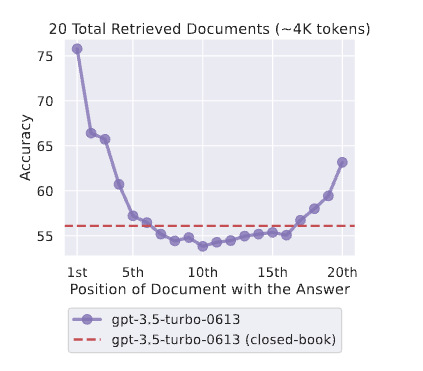

```python
def _litm_reordering(documents: List[Document]) -> List[Document]:
    """Lost in the middle reorder: the less relevant documents will be at the
    middle of the list and more relevant elements at beginning / end.
    See: https://arxiv.org/abs//2307.03172"""

    documents.reverse()
    reordered_result = []
    for i, value in enumerate(documents):
        if i % 2 == 1:
            reordered_result.append(value)
        else:
            reordered_result.insert(0, value)
    return reordered_result
```



In [ ]:
from langchain_community.document_transformers import LongContextReorder

# 덜 관련성 있는 문서는 리스트의 중간에 위치하고, 더 관련성 있는 문서는 리스트의 시작과 끝에 위치하게 됩니다.
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(compressed_docs)

# 관련 문서가 리스트의 시작과 끝에 위치하는지 확인합니다.
for doc in reordered_docs:
  print(doc.metadata, doc)

{'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web page and blog, focusing on white space and readability\n', 'language': 'en'} page_content='ChemCrow 에이전트는 유기 합성, 약물 발견 및 재료 설계를 포함한 작업을 완료하기 위해 설계되었음.\n복잡한 추론 및 상식 이해 능력 덕분에 LLM 기반 에이전트가 효과적으로 사용된 다양한 분야와 사례 연구를 강조합니다.' metadata={'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web page and blog, focusing on white space and readability\n', 'language': 'en'}
{'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web page and blog, focusing on white space and rea

### 💫 Reranker

RAG 시스템에서, 검색기는 많은 문서 중에서 관련 문서를 빠르게 찾는 것을 목표로 합니다. 하지만 검색기는 주로 속도에 최적화되어 있어, 검색된 문서의 순위가 항상 최적이 아닐 수 있습니다. 여기서 reranker의 필요성이 생깁니다.

reranker는 더 강력한 모델을 사용하여 문서의 순위를 다시 매기는 방법입니다. 쿼리와 문서 간의 맥락을 더 깊이 고려하여 관련성 점수를 계산하기 때문에 관련 있는 문서를 훨씬 잘 찾아냅니다.

reranker에 대한 더 자세한 설명은 [이 문서](https://www.toolify.ai/ko/ai-news-kr/cohere-rag-rerankers-990927)에서 확인할 수 있습니다.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

rerank_model_name = "Dongjin-kr/ko-reranker"
rerank_tokenizer = AutoTokenizer.from_pretrained(rerank_model_name)
rerank_model = AutoModelForSequenceClassification.from_pretrained(rerank_model_name)
rerank_model.eval()

def exp_normalize(scores):
    b = scores.max()
    y = np.exp(scores - b)
    return y / y.sum()

def rerank_docs(query, docs):
    pairs = [[query, doc.page_content] for doc in docs]
    with torch.no_grad():
        inputs = rerank_tokenizer(
            pairs, padding=True, truncation=True, return_tensors="pt", max_length=512
        )
        logits = rerank_model(**inputs, return_dict=True).logits.view(-1).float()
        scores = exp_normalize(logits.numpy())

    return sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [ ]:
for doc in rerank_docs(query="LLM 에이전트는 무엇으로 이루어져 있나요?", docs=compressed_docs):
  print(doc)

(Document(page_content='LLM 에이전트는 다음과 같은 핵심 구성 요소로 이루어질 수 있습니다:\n\n사용자 요청(User Request) - 사용자의 질문이나 요청\n에이전트(Agent)/두뇌(Brain) - 관리자의 역할을 하는 에이전트의 핵심\n계획(Planning) - 에이전트가 미래 행동을 계획하는 것을 도움\n메모리(Memory) - 에이전트의 과거 행동을 관리', metadata={'source': 'https://harheem.github.io/llm/2024/02/28/llm-agents.html', 'title': ' LLM Agents — Prompt Engineering Guide 한글화 - LLM Agents  | harheem', 'description': 'A simple, minimal Jekyll theme for a personal web page and blog, focusing on white space and readability\n', 'language': 'en'}), 0.9997402)
(Document(page_content='에이전트\n대규모 언어 모델(LLM)은 시스템의 핵심 두뇌로서, 에이전트 모듈이나 관리자의 역할을 수행합니다. 이 구성 요소는 에이전트의 작동 방식과 접근 가능한 도구(도구의 세부 정보 포함)에 대한 중요한 세부 정보를 담은 프롬프트 템플릿을 통해 활성화됩니다.\n필수는 아니지만, 에이전트는 특정 역할이나 특성을 가진 페르소나로 프로파일링될 수 있습니다. 이 프로파일링 정보는 주로 프롬프트에 기재되며, 역할 세부 정보, 성격, 사회적 배경, 인구 통계적 정보 등 구체적인 사항을 포함할 수 있습니다. Wang et al. 2023에 따르면, 에이전트 프로파일을 정의하는 방법으로는 수작업, LLM 생성, 데이터 기반 접근법이 있습니다.\n계획\n피드백이 없는 계획\n계획 모듈은 에이전트가 사용자의 요청에 답하기 위해 해결해야 할 단계나 하위 작업들을 세분화하는 데 도움을 줍니다.

### 🤝 [Ensemble Retriever (hybrid search)](https://python.langchain.com/v0.2/docs/how_to/ensemble_retriever/)

EnsembleRetriever는 여러 검색기의 결과를 하나로 통합해 제공합니다. 이 검색기는 다양한 검색기의 결과를 [RRF(Reciprocal Rank Fusion) 알고리즘](https://learn.microsoft.com/ko-kr/azure/search/hybrid-search-ranking)을 통해 재정렬합니다. 이 방식은 각각의 검색기의 특성을 적절히 활용하여, 하나의 검색기만 사용할 때보다 뛰어난 성능을 발휘할 수 있습니다.

희소 검색기와 밀집 검색기는 각각 서로 다른 장점을 가지고 있기 때문에 많은 상황에서 조합하여 사용하고 있습니다. 희소 검색기는 키워드 기반으로 문서를 효과적으로 찾아내고, 밀집 검색기는 문서 간의 의미적 유사성을 파악하는 데 강점을 가집니다. 이러한 하이브리드 접근 방식은 검색 결과의 정확성과 품질을 크게 향상시킵니다.

In [ ]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from kiwipiepy import Kiwi

kiwi = Kiwi()
text_docs = [doc.page_content for doc in texts]

def preprocessing_with_kiwi(text):
  return [t.form for t in kiwi.tokenize(text)]

# initialize the bm25 retriever and faiss retriever
bm25_retriever = BM25Retriever.from_texts(
    text_docs,
    metadatas=[{"source": 'bm25'}] * len(text_docs),
    preprocess_func=preprocessing_with_kiwi
)
bm25_retriever.k = 2


faiss_vectorstore = FAISS.from_texts(
    text_docs, embedding_model, metadatas=[{"source": 'faiss'}] * len(text_docs)
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)

In [ ]:
docs = ensemble_retriever.invoke("LLM 에이전트의 성능 평가 방법?")
for doc in docs:
    print(doc.metadata, doc)

{'source': 'bm25'} page_content='인간 주석(Human Annotation): 인간 평가자가 정직성, 유용성, 참여도, 편견 없음 등 애플리케이션에서 중요한 다양한 측면에서 LLM 결과를 직접 평가합니다.\n튜링 테스트(Turing Test): 인간 평가자는 실제 인간과 에이전트의 결과를 비교하여 구별할 수 없는 결과가 나오면 에이전트가 인간 수준의 성능을 달성했다고 볼 수 있습니다.\n메트릭(Metrics): 에이전트의 품질을 반영하기 위해 세심하게 설계된 지표들입니다. 주요 메트릭으로는 작업 성공률, 인간 유사성, 효율성 등이 있습니다.\n프로토콜(Protocols): 메트릭이 어떻게 사용되는지를 결정하는 일반적인 평가 방식입니다. 예를 들어 실제 세계 시뮬레이션, 사회적 평가, 다중 작업 평가, 소프트웨어 테스팅 등이 있습니다.\n벤치마크(Benchmarks): LLM 에이전트를 평가하기 위해 설계된 여러 벤치마크가 있습니다. 주목할 만한 예시로는 ALFWorld(opens in a new tab),\xa0IGLU(opens in a new tab),\xa0Tachikuma(opens in a new tab),\xa0AgentBench(opens in a new tab),\xa0SocKET(opens in a new tab),\xa0AgentSims(opens in a new tab),\xa0ToolBench(opens in a new tab),\xa0WebShop(opens in a new tab),\xa0Mobile-Env(opens in a new tab),\xa0WebArena(opens in a new tab),\xa0GentBench(opens in a new tab),\xa0RocoBench(opens in a new tab),\xa0EmotionBench(opens in a new tab),\xa0PEB(opens in a new tab),\xa0ClemBench(opens in a new tab),\xa0E2E(o

#### BM25를 사용할 때는 🥝

In [ ]:
#def default_preprocessing_func(text: str) -> List[str]:
#    return text.split()

"어텐션 메커니즘의 종류에 대해서 알려주세요.".split()

['어텐션', '메커니즘의', '종류에', '대해서', '알려주세요.']

In [ ]:
from kiwipiepy import Kiwi

kiwi = Kiwi()
kiwi.tokenize("어텐션 메커니즘의 종류에 대해서 알려주세요.")

[Token(form='어텐션', tag='NNG', start=0, len=3),
 Token(form='메커니즘', tag='NNG', start=4, len=4),
 Token(form='의', tag='JKG', start=8, len=1),
 Token(form='종류', tag='NNG', start=10, len=2),
 Token(form='에', tag='JKB', start=12, len=1),
 Token(form='대하', tag='VV', start=14, len=2),
 Token(form='어서', tag='EC', start=15, len=2),
 Token(form='알리', tag='VV', start=18, len=2),
 Token(form='어', tag='EC', start=19, len=1),
 Token(form='주', tag='VX', start=20, len=1),
 Token(form='세요', tag='EF', start=21, len=2),
 Token(form='.', tag='SF', start=23, len=1)]

## 마무리

### 📄 일단 데이터부터

RAG 시스템을 사용할 때, 입력 데이터의 질이 결과의 질을 결정합니다. 만약 입력 데이터가 부정확하거나 관련성이 낮은 정보를 포함하고 있다면, 아무리 고급의 검색기를 사용한다 해도 생성된 결과는 만족스럽지 못할 것입니다. 다양한 검색 기법을 알아두는 것은 도움이 되지만, 데이터의 질을 높이는 것에 집중해보세요.

> 💡 TIP
- 메타데이터를 활용하여 원하는 문서를 보다 정확하게 검색해 보세요.
- 문서의 특성을 파악하여 적절한 사이즈로 청크를 나누어 성능을 개선해보세요.


### 💸 성능과 비용 사이에서

성능을 향상시키려는 모든 노력은 비용을 수반합니다. 예를 들어, Multi-Query나 Re-ranking 기술을 사용하면 검색 결과는 개선되지만, 첫 토큰을 받기까지의 시간이 길어질 수 있습니다.

대규모 시스템에서는 이러한 지연(latency)과 같은 추가 비용이 더욱 눈에 띄게 됩니다. 따라서 각 기능을 추가할 때는 그 기능이 실제로 사용자 경험을 얼마나 향상시키는지를 고려하여 비용 대비 효과를 신중하게 따져보아야 합니다.

실제 환경에서 성능을 테스트하여 그 가치를 확인하고, 이러한 도구들을 효과적으로 활용하여 사용자 경험을 개선해 보세요.